# EFIMM0142: Modelling Analytics
> Group Assignment - Site Selection

## Import Libraries & Datasets

In [ ]:
# Standard Libraries
import os
import time
import uuid
import math

# Data Handling Libraries
import numpy as np
import pandas as pd

# Geospatial Libraries
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from shapely.ops import unary_union
import osmnx as ox
import networkx as nx

# Optimization Libraries
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary, LpStatus
from pyomo.environ import *

# Machine Learning Libraries
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

# Statistical and Spatial Analysis Libraries
from scipy.spatial import distance
from scipy.stats import gaussian_kde

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, FancyArrowPatch
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import seaborn as sns

# Progress Monitoring Libraries
from tqdm import tqdm

# IPython Display for Notebooks (if using Jupyter)
from IPython.display import display

# Activate tqdm progress bar for pandas (if using Jupyter)
tqdm.pandas()

In [ ]:
# Read the shapefiles
pop = gpd.read_file("Data/Population_by_Output_Area_2022/Population_estimates_by_single_year_of_age_and_sex_by_Output_Area.shp")
charging_points = gpd.read_file("Data/Electric_Vehicle_Charging_Points_2024/Electric_vehicle_charging_points_NCR.shp")
parking_points = gpd.read_file("Data/Designated_Car_Parks_2024/Designated_car_parks.shp")
life_style = gpd.read_file("Data/Quality_of_Life_2018/Quality_of_Life_2017_to_2018_(ward).shp")
boundary = gpd.read_file("Data/Bristol_Boundary_2023/Bristol_boundary.shp")

In [ ]:
# Read csv file
ev_ownership = pd.read_csv("Data/Electric_Vehicle_Ownership_2021/electricvehicles_2021.csv")

In [ ]:
# Convert all GeoDataFrames to the same CRS (EPSG:27700)
crs_epsg27700 = 'EPSG:27700'
datasets = [pop, charging_points, parking_points, life_style, boundary]
for dataset in datasets:
    if dataset.crs != crs_epsg27700:
        dataset.to_crs(crs_epsg27700, inplace=True)

### Population

In [ ]:
print(pop.crs)
pop

EPSG:27700


OBJECTID  OA21_CODE LSOA21_COD    LSOA21_ONS               LSOA21_LOC  \
0            1  E00073143  E01014485  Bristol 058A                Mina Road   
1            2  E00073145  E01033366  Bristol 059B  St Pauls Grosvenor Road   
2            3  E00073147  E01014486  Bristol 058C                 St Agnes   
3            4  E00073148  E01033348  Bristol 059C       St Pauls City Road   
4            5  E00073150  E01014486  Bristol 058C                 St Agnes   
...        ...        ...        ...           ...                      ...   
1400      1401  E00178115  E01033910  Bristol 061E           Bathurst Basin   
1401      1402  E00178116  E01033366  Bristol 059B  St Pauls Grosvenor Road   
1402      1403  E00178117  E01033359  Bristol 039E          Bedminster East   
1403      1404  E00178118  E01014583  Bristol 044B         Throgmorton Road   
1404      1405  E00178119  E01032515  Bristol 053F     Whitchurch Park West   

     MSOA21_COD   MSOA21_ONS                   MSOA21_LOC WARD_CODE_  \
0     E02006949  Bristol 058                 St Werburghs  E05010885   
1     E02006950  Bristol 059                     St Pauls  E05010885   
2     E02006949  Bristol 058                 St Werburghs  E05010885   
3     E02006950  Bristol 059                     St Pauls  E05010885   
4     E02006949  Bristol 058                 St Werburghs  E05010885   
...         ...          ...                          ...        ...   
1400  E02006952  Bristol 061  City Centre and Harbourside  E05010892   
1401  E02006950  Bristol 059                     St Pauls  E05010885   
1402  E02003050  Bristol 039                   Bedminster  E05010914   
1403  E02003055  Bristol 044                       Knowle  E05010898   
1404  E02003064  Bristol 053                   Hartcliffe  E05010902   

                        WARD_NAME_  ...  FEMALE84  FEMALE85  FEMALE86  \
0                           Ashley  ...         0         0         0   
1                           Ashley  ...         0         0         0   
2                           Ashley  ...         2         2         0   
3                           Ashley  ...         0         0         0   
4                           Ashley  ...         1         0         0   
...                            ...  ...       ...       ...       ...   
1400                       Central  ...         0         0         0   
1401                        Ashley  ...         0         0         0   
1402                    Southville  ...         0         0         0   
1403                       Filwood  ...         0         0         0   
1404  Hengrove and Whitchurch Park  ...         1         1         2   

      FEMALE87  FEMALE88  FEMALE89  FEMALE90     ShapeSTAre   ShapeSTLen  \
0            0         0         1         0   22856.058451   682.209695   
1            0         1         0         0   19121.099783   796.829556   
2            0         0         0         0   63607.163768  1454.514983   
3            0         0         0         0   22775.678644   709.041606   
4            0         0         0         0   51775.929354  1409.806224   
...        ...       ...       ...       ...            ...          ...   
1400         0         0         0         0   27364.316043   906.514772   
1401         0         0         0         0    8540.314600   403.427631   
1402         0         1         0         1  207063.527162  2832.252939   
1403         0         0         0         0   87558.690701  1398.486989   
1404         2         0         1         4  232374.763845  2441.158679   

                                               geometry  
0     POLYGON ((360354.402 174607.970, 360375.000 17...  
1     POLYGON ((359385.170 174086.827, 359477.689 17...  
2     POLYGON ((359806.251 174231.617, 359857.141 17...  
3     POLYGON ((359297.173 174014.188, 359314.361 17...  
4     POLYGON ((359998.549 174309.475, 359992.265 17...  
...                                                 ..

### Charging Points

In [ ]:
print(charging_points.crs)
charging_points

EPSG:27700


OBJECTID                          DeviceId       DeviceRef  \
0           1  50dd7100bcbd98c41b1179143a2325a4        PP-12614   
1           2  f1d32765fb6215ed9ba20bd9e59733b8      PP-5112289   
2           3  492976d6fcdd5205b1ddf77458d42a39        PP-12791   
3           4  df952959a69bbc4cf649113a7cc59cd6      PP-5112218   
4           5  1a534df4ec7023f89613a24be21a149f      PP-5112351   
..        ...                               ...             ...   
419       420  1f4ca5cf79e3e8f5860074fb856d2b4e  bill-city-look   
420       421  c7dced801f1e05f678f3b53be7d32cb7  look-hair-road   
421       422  b43df13ae0d51f7dbba35cfd6e91f77f         5238-CK   
422       423  e375ad4425cae7b8089f5031866e58d9         5239-CK   
423       424  f8dfa1bc1dfc7fe4bbd53f1aeb099deb         5240-CK   

                      DeviceName DeviceText SubBuildin  \
0          Nissan Wessex Bristol       None       None   
1    Charlotte Street Car Park 1       None       None   
2    Charlotte Street Car Park 2       None       None   
3             Motability Bristol       None       None   
4         Odd Down Park & Ride 2       None       None   
..                           ...        ...        ...   
419          zest-bill-city-look       None       None   
420          zest-look-hair-road       None       None   
421      Gallagher Shopping Park       None       None   
422      Gallagher Shopping Park       None       None   
423      Gallagher Shopping Park       None       None   

                    BuildingNa BuildingNu            Thoroughfa  \
0                         None       None  Frome Valley Walkway   
1    Charlotte Street Car Park          9      Charlotte Street   
2                         None          9      Charlotte Street   
3                         None       None                  None   
4       Odd Down Park and Ride       None        Combe Hay Lane   
..                         ...        ...                   ...   
419      Filton Leisure Centre       None                  None   
420      Filton Leisure Centre       None                  None   
421                       None       None                  None   
422                       None       None                  None   
423                       None       None                  None   

                                                Street  ... PhysRest_1  \
0                                                 None  ...       None   
1                                                 None  ...       None   
2                                                 None  ...       None   
3    Bristol Park House, 610 Bristol Business Park,...  ...       None   
4                                                 None  ...       None   
..                                                 ...  ...        ...   
419                                           Elm Park  ...       None   
420                                           Elm Park  ...       None   
421                                      Aldermoor Way  ...       None   
422                                      Aldermoor Way  ...       None   
423                                      Aldermoor Way  ...       None   

    OnStreet LocationTy Bearing Access24Ho        Easting       Northing  \
0        Yes      Other    None        Yes  359275.202947  174086.617293   
1        Yes      Other    None        Yes  374568.715939  165016.839934   
2        Yes      Other    None        Yes  374559.182147  165016.887792   
3        Yes      Other    None        Yes  362384.850082  178209.164724   
4        Yes      Other    None        Yes  373304.345834  161438.720183   
..       ...        ...     ...        ...            ...            ...   
419       No      Other    None         No  360261.468520  178785.832673   
420       No      Other    None         No  360261.468520  178785.832673   
421       No  On-street    None         No  365476.479095  171990.818997   
422       No  On-street    None         No  36547

### Candidate Points

In [ ]:
print(parking_points.crs)
parking_points

EPSG:27700


OBJECTID                                         BLOCK_NAME  \
0          1                                      Ashmead House   
1          2                                       Barton House   
2          3                                       Barton House   
3          4                                     Beaufort House   
4          5                                    Eccleston House   
5          6                                      Harwood House   
6          7                                    Longlands House   
7          8                                      Phoenix House   
8          9                                      Croydon House   
9         10                                      Croydon House   
10        11                                      Croydon House   
11        12                                     Rawnsley House   
12        13                                     Rawnsley House   
13        14                                     Rawnsley House   
14        15                                     Twinnell House   
15        16                                      Brandon House   
16        17                                      Brandon House   
17        18                                     Chestnut House   
18        19                                     Hayleigh House   
19        20                                   Middleford House   
20        21                                     Millmead House   
21        22                                          Oak House   
22        23                                      Redwood House   
23        24                                        Rowan House   
24        25                                       Willow House   
25        26                                       Armada House   
26        27                                     Carolina House   
27        28                                     Carolina House   
28        29                                      Francis House   
29        30                                    Fremantle House   
30        31                                   Gloucester House   
31        32                                     Somerset House   
32        33                                       Wessex House   
33        34                                   Chatterton House   
34        35                                    Francombe House   
35        36                        Norton House, Spencer House   
36        37                        Norton House, Spencer House   
37        38                                    Underdown House   
38        39                                       Waring House   
39        40                                    Penrith Gardens   
40        41                                    Penrith Gardens   
41        42  Charlton House, Haviland House, Langton House,...   
42        43                                        Elton House   
43        44                                     Elbridge House   
44        45                                     Ropewalk House   
45        46                                  St Matthias House   
46        47                                      Tyndall House   
47        48                                      Whitson House   
48        49                                      Corbett House   
49        50                                        Dorian Road   
50        51                                   Strawbridge Road   
51        52                                    Broughton House   
52        53                                      Yeamans House   
53        54                                         Mede Close   
54        55                                      Canynge House   
55        56                                     Plimsoll House   
56        57                                  Winterstoke House   
57        58                                      Gaywood House   

                         geometry  
0   POINT (361

### Life Style

In [ ]:
print(life_style.crs)
life_style

EPSG:27700


FID indicator_                                          indicator  \
0        1  IQOL17104  % children aged 7 to 10 who travel to school u...   
1        2  IQOL17045  % who think domestic abuse doesn't really happ...   
2        3  IQOL17146  % shift workers who had no other alternatives ...   
3        4  IQOL17010  % who think noise from pubs, clubs and enterta...   
4        5  IQOL17017                    % who help out their neighbours   
...    ...        ...                                                ...   
7240  7241  IQOL17076     % who never participate in cultural activities   
7241  7242  IQOL17082  % who have access to the internet at home via ...   
7242  7243  IQOL17094  % who have reduced their household waste due t...   
7243  7244  IQOL17032  % for whom inaccessible public transport preve...   
7244  7245  IQOL17129                                      % underweight   

                             theme  \
0                        Transport   
1                   Crime & Safety   
2                       Employment   
3               Community & Living   
4               Community & Living   
...                            ...   
7240             Culture & Leisure   
7241            Community & Living   
7242  Sustainability & Environment   
7243                     Transport   
7244            Health & Wellbeing   

                                             theme_indi  ward_code  \
0     Transport/% children aged 7 to 10 who travel t...  E05010915   
1     Crime & Safety/% who think domestic abuse does...  E05010916   
2     Employment/% shift workers who had no other al...  E05010916   
3     Community & Living/% who think noise from pubs...  E05010917   
4     Community & Living/% who help out their neighb...  E05010917   
...                                                 ...        ...   
7240  Culture & Leisure/% who never participate in c...  E05010895   
7241  Community & Living/% who have access to the in...  E05010895   
7242  Sustainability & Environment/% who have reduce...  E05010898   
7243  Transport/% for whom inaccessible public trans...  E05010900   
7244                   Health & Wellbeing/% underweight  E05010900   

                        ward_name            survey_que sample_siz  statistic  \
0                       Stockwood         Q17077 Q17078       None   0.000000   
1                    Stoke Bishop                Q17026        111  11.243311   
2                    Stoke Bishop         Q17107 Q17109       None   0.000000   
3     Westbury-on-Trym & Henleaze                Q17010        176   2.566639   
4     Westbury-on-Trym & Henleaze                Q17016        185  39.282256   
...                           ...                   ...        ...        ...   
7240                       Cotham                Q17054        117   2.393873   
7241                       Cotham                Q17058        117  38.614288   
7242                      Filwood                Q17066         61  48.707079   
7243       Hartcliffe & Withywood                Q17019         97   6.250035   
7244       Hartcliffe & Withywood  Q17094 Q17095 Q17096         77   8.075019   

      standard_e  lower_conf  upper_conf    Shape__Are    Shape__Len  \
0       0.000000    0.000000    0.000000  8.337309e+06  13499.892964   
1       4.123331    5.335363   22.161712  1.476445e+07  17736.962202   
2       0.000000    0.000000    0.000000  1.476445e+07  17736.962202   
3       1.014920    1.175065    5.514233  1.353607e+07  19550.462286   
4       3.868246   32.009412   47.063712  1.353607e+07  19550.462286   
...          ...         ...         ...           ...           ...   
7240    1.681414    0.594962    9.132237  2.584107e+06   8286.493880   
7241    5.980273   27.726887   50.773441  2.584107e+06   8286.493880   
7242    7.280598   34.912010   62.701971  7.301387e+06  12791.509673   
7243    2.374868    2.924262   12.857254  9.270168e+06  16739.132485   
7244    4.278752    2.759914   

### Boundary

In [ ]:
print(life_style.crs)
boundary

EPSG:27700


OBJECTID    CITY_AREA_    CITY_ARE_1    CITY_PERIM    SHAPESTAre  \
0         1  1.115430e+08  11154.295722  74771.899464  1.115430e+08   

     SHAPESTLen                                           geometry  
0  74771.545826  POLYGON ((350000.100 178326.800, 350350.853 17...

### Proportion of Electric Vehicles

In [ ]:
ev_ownership

per_type  age_16_29  age_30_49  age_50_69  age_over_70
0  car_owner       0.35       0.70       0.75         0.74
1     hybrid       0.00       0.02       0.03         0.02
2   electric       0.04       0.03       0.03         0.02

### Road Network

In [ ]:
# Define the place name for Bristol, UK
place_name = "Bristol, United Kingdom"

# Download the road network for Bristol
bristol_road_network = ox.graph_from_place(place_name, network_type='all')
print(bristol_road_network.graph['crs'])

epsg:4326


In [ ]:
# Convert the road network to the CRS of the population data
bristol_road_network = ox.project_graph(bristol_road_network, to_crs='epsg:27700')
print(bristol_road_network.graph['crs'])

epsg:27700


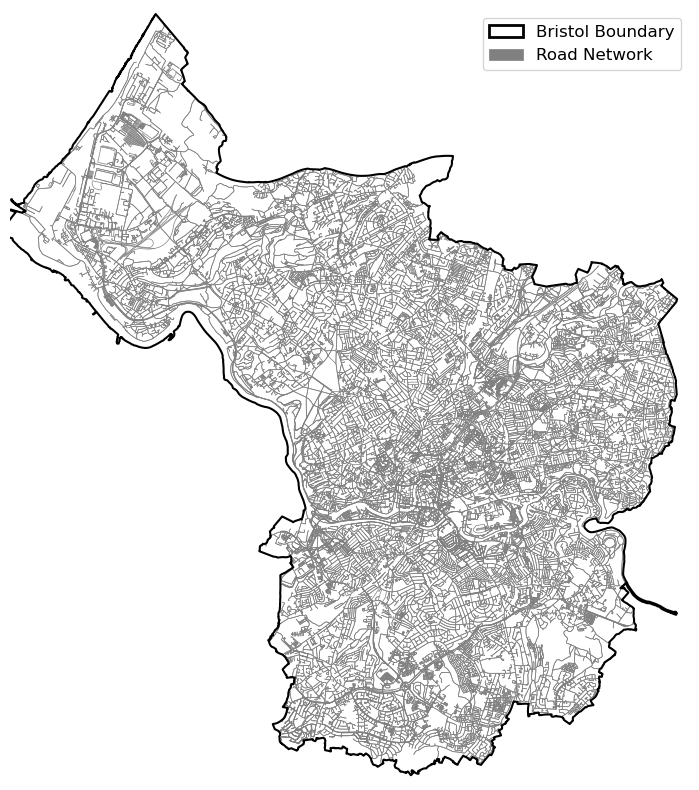

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the road network
ox.plot_graph(
    bristol_road_network,
    ax=ax,
    node_size=0,  # Hide nodes for a cleaner look
    edge_color='gray',  # Set a softer color for roads
    edge_linewidth=0.5,  # Increase line width for better visibility
    bgcolor='#f5f5f5',  # Set a light grey background color
    show=False,
    close=False
)

# Overlay the boundary with a thicker blue outline
boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')

# Add a legend to distinguish elements
legend_elements = [
    Patch(edgecolor='black', linewidth=2, facecolor='none', label='Bristol Boundary'),
    Patch(edgecolor='gray', linewidth=0.5, facecolor='gray', label='Road Network')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Customize the plot
ax.grid(visible=True, linestyle='--', linewidth=0.5, color='lightgray')  # Light grid lines
ax.set_xticks([])
ax.set_yticks([])

# Show the enhanced plot
plt.show()

## Part 1: Data Cleaning

## Data Cleaning for Charging Points

In [ ]:
# Filter for 'In service' devices and remove private charging points
charging_points = charging_points[
    (charging_points['DeviceStat'] == 'In service') &
    (~charging_points[['DeviceText', 'LocationSh', 'LocationLg', 'AccRestr_1']]
     .apply(lambda x: x.str.contains('Private', case=False, na=False)).any(axis=1))
]

charging_points

OBJECTID                          DeviceId       DeviceRef  \
0           1  50dd7100bcbd98c41b1179143a2325a4        PP-12614   
1           2  f1d32765fb6215ed9ba20bd9e59733b8      PP-5112289   
2           3  492976d6fcdd5205b1ddf77458d42a39        PP-12791   
3           4  df952959a69bbc4cf649113a7cc59cd6      PP-5112218   
4           5  1a534df4ec7023f89613a24be21a149f      PP-5112351   
..        ...                               ...             ...   
419       420  1f4ca5cf79e3e8f5860074fb856d2b4e  bill-city-look   
420       421  c7dced801f1e05f678f3b53be7d32cb7  look-hair-road   
421       422  b43df13ae0d51f7dbba35cfd6e91f77f         5238-CK   
422       423  e375ad4425cae7b8089f5031866e58d9         5239-CK   
423       424  f8dfa1bc1dfc7fe4bbd53f1aeb099deb         5240-CK   

                      DeviceName DeviceText SubBuildin  \
0          Nissan Wessex Bristol       None       None   
1    Charlotte Street Car Park 1       None       None   
2    Charlotte Street Car Park 2       None       None   
3             Motability Bristol       None       None   
4         Odd Down Park & Ride 2       None       None   
..                           ...        ...        ...   
419          zest-bill-city-look       None       None   
420          zest-look-hair-road       None       None   
421      Gallagher Shopping Park       None       None   
422      Gallagher Shopping Park       None       None   
423      Gallagher Shopping Park       None       None   

                    BuildingNa BuildingNu            Thoroughfa  \
0                         None       None  Frome Valley Walkway   
1    Charlotte Street Car Park          9      Charlotte Street   
2                         None          9      Charlotte Street   
3                         None       None                  None   
4       Odd Down Park and Ride       None        Combe Hay Lane   
..                         ...        ...                   ...   
419      Filton Leisure Centre       None                  None   
420      Filton Leisure Centre       None                  None   
421                       None       None                  None   
422                       None       None                  None   
423                       None       None                  None   

                                                Street  ... PhysRest_1  \
0                                                 None  ...       None   
1                                                 None  ...       None   
2                                                 None  ...       None   
3    Bristol Park House, 610 Bristol Business Park,...  ...       None   
4                                                 None  ...       None   
..                                                 ...  ...        ...   
419                                           Elm Park  ...       None   
420                                           Elm Park  ...       None   
421                                      Aldermoor Way  ...       None   
422                                      Aldermoor Way  ...       None   
423                                      Aldermoor Way  ...       None   

    OnStreet LocationTy Bearing Access24Ho        Easting       Northing  \
0        Yes      Other    None        Yes  359275.202947  174086.617293   
1        Yes      Other    None        Yes  374568.715939  165016.839934   
2        Yes      Other    None        Yes  374559.182147  165016.887792   
3        Yes      Other    None        Yes  362384.850082  178209.164724   
4        Yes      Other    None        Yes  373304.345834  161438.720183   
..       ...        ...     ...        ...            ...            ...   
419       No      Other    None         No  360261.468520  178785.832673   
420       No      Other    None         No  360261.468520  178785.832673   
421       No  On-street    None         No  365476.479095  171990.818997   
422       No  On-street    None         No  36547

### Filter Points With the Boundary

In [ ]:
# Crop `charging_points` to retain only points within the boundary
charging_points = gpd.sjoin(charging_points, boundary, op='within')
charging_points

C:\Users\Sigao Li\.conda\envs\py310\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


OBJECTID_left                          DeviceId          DeviceRef  \
0                1  50dd7100bcbd98c41b1179143a2325a4           PP-12614   
6                7  7b5fb650c7bca123d83dd9cf7f7f9bca         PP-5112282   
14              15  88692f34e175f423ac0ebf267c158e2e    60401/02 /48/49   
15              16  16644a3ed5102e32e7fa6cfb3fd5d00a  60408/42/43/40/41   
16              17  b4382895819caad3a3cdb580eff83351      60444 / 60445   
..             ...                               ...                ...   
396            397  4bef728cf44f6ee697114649e80ae191       GBBPCE615451   
398            399  351345f28c627ecce65526fd115467f7      GBBPCE1093432   
399            400  77195c4e029ba71a2e914ba4f867274e       GBBPCE923811   
400            401  597dd91e6b177f393877f173f231593f       GBBPCE923812   
401            402  b88f071fefbec84cdcd534fe9ac19b17      GBBPCE1093431   

                        DeviceName DeviceText SubBuildin BuildingNa  \
0            Nissan Wessex Bristol       None       None       None   
6           Wessex Garages Bristol       None       None       None   
14     Trenchard Street Car Park 1   Car Park       None       None   
15             West End Car Park 1   Car Park       None       None   
16          Temple Gate Car Park 2   Car Park       None       None   
..                             ...        ...        ...        ...   
396  DTM Ltd (Bosch service place)       None       None       None   
398              Hilton Garden Inn       None       None       None   
399              Hilton Garden Inn       None       None       None   
400              Hilton Garden Inn       None       None       None   
401              Hilton Garden Inn       None       None       None   

    BuildingNu            Thoroughfa  \
0         None  Frome Valley Walkway   
6         None                  None   
14          18      Trenchard Street   
15        None        Berkeley Place   
16        None     Chatterton Square   
..         ...                   ...   
396       None                  None   
398       None                  None   
399       None                  None   
400       None                  None   
401       None                  None   

                                            Street  ...   Latitude Longitude  \
0                                             None  ...  51.464275 -2.587624   
6                          Pennywell Road, Bristol  ...  51.463846 -2.576274   
14                                    Lodge Street  ...  51.454990 -2.599656   
15                               Jacobs Wells Road  ...  51.455708 -2.609360   
16                                     Temple Gate  ...  51.448183 -2.584233   
..                                             ...  ...        ...       ...   
396  DTM Ltd (Bosch service place), Short Street S  ...  51.448597 -2.570181   
398                  Hilton Garden Inn, Temple way  ...  51.452049 -2.584610   
399                  Hilton Garden Inn, Temple way  ...  51.452049 -2.584610   
400                  Hilton Garden Inn, Temple way  ...  51.452049 -2.584610   
401                  Hilton Garden Inn, Temple way  ...  51.452049 -2.584610   

                          geometry index_right OBJECTID_right    CITY_AREA_  \
0    POINT (359275.203 174086.617)           0              1  1.115430e+08   
6    POINT (360063.270 174032.635)           0              1  1.115430e+08   
14   POINT (358430.924 173060.818)           0              1  1.115430e+08   
15   POINT (357757.356 173146.242)           0              1  1.115430e+08   
16   POINT (359496.511 172295.122)           0              1  1.115430e+08   
..                             ...         ...            ...           ...   
396  POINT (360473.367 172333.454)           0              1  1.115430e+08   
398  POINT (359473.733 172725.279)           0              1  1.115430e+08   
399  POINT (359473.733 172725.279)           0              1  1.115430e+08   
400  POINT (359473.

In [ ]:
# Crop `parking_points` to retain only points within the boundary
parking_points = gpd.sjoin(parking_points, boundary, op='within')
parking_points

C:\Users\Sigao Li\.conda\envs\py310\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


OBJECTID_left                                         BLOCK_NAME  \
0               1                                      Ashmead House   
1               2                                       Barton House   
2               3                                       Barton House   
3               4                                     Beaufort House   
4               5                                    Eccleston House   
5               6                                      Harwood House   
6               7                                    Longlands House   
7               8                                      Phoenix House   
8               9                                      Croydon House   
9              10                                      Croydon House   
10             11                                      Croydon House   
11             12                                     Rawnsley House   
12             13                                     Rawnsley House   
13             14                                     Rawnsley House   
14             15                                     Twinnell House   
15             16                                      Brandon House   
16             17                                      Brandon House   
17             18                                     Chestnut House   
18             19                                     Hayleigh House   
19             20                                   Middleford House   
20             21                                     Millmead House   
21             22                                          Oak House   
22             23                                      Redwood House   
23             24                                        Rowan House   
24             25                                       Willow House   
25             26                                       Armada House   
26             27                                     Carolina House   
27             28                                     Carolina House   
28             29                                      Francis House   
29             30                                    Fremantle House   
30             31                                   Gloucester House   
31             32                                     Somerset House   
32             33                                       Wessex House   
33             34                                   Chatterton House   
34             35                                    Francombe House   
35             36                        Norton House, Spencer House   
36             37                        Norton House, Spencer House   
37             38                                    Underdown House   
38             39                                       Waring House   
39             40                                    Penrith Gardens   
40             41                                    Penrith Gardens   
41             42  Charlton House, Haviland House, Langton House,...   
42             43                                        Elton House   
43             44                                     Elbridge House   
44             45                                     Ropewalk House   
45             46                                  St Matthias House   
46             47                                      Tyndall House   
47             48                                      Whitson House   
48             49                                      Corbett House   
49             50                                        Dorian Road   
50             51                                   Strawbridge Road   
51             52                                    Broughton House   
52             53                                      Yeamans House   
53             54                                         Mede Close   
54             55                           

In [ ]:
# total_parking_spots = parking_points['Charging_spots'].sum()
# total_parking_spots

### Estimated Number of Electric Vehicles

In [ ]:
# Calculate age group
age_groups = {
    'age_16_29': range(16, 30),
    'age_30_49': range(30, 50),
    'age_50_69': range(50, 70),
    'age_over_70': range(70, 91)
}

for group_name, ages in age_groups.items():
    male_cols = [f"MALE{age}" for age in ages]
    female_cols = [f"FEMALE{age}" for age in ages]
    pop[group_name] = pop[male_cols + female_cols].sum(axis=1)

# Verify the results
pop[["age_16_29", "age_30_49", "age_50_69", "age_over_70"]].head()

age_16_29 age_30_49  age_50_69 age_over_70
0         84       111         62          15
1        149       138         62          13
2        167       165         71          22
3        130       122         44           2
4        159       140         91          15

In [ ]:
# Get the multiplier value for each age group based on "hybrid" and "electric" ownership rates
ev_multiplier = ev_ownership.loc[
    ev_ownership["per_type"].isin(["hybrid", "electric"]),
    ["age_16_29", "age_30_49", "age_50_69", "age_over_70"]
].sum().values

# Calculate 'ev_owner' for each area
car_ownership = ev_ownership.loc[ev_ownership["per_type"] == "car_owner"].iloc[0]
pop["ev_owner"] = sum(
    pop[age_group] * car_ownership[age_group] * ev_multiplier[idx]
    for idx, age_group in enumerate(age_groups.keys())
)

# Verify the results
pop[["ev_owner"]].head()

ev_owner
0    8.295
1  10.0908
2  11.9592
3   8.1292
4   11.665

### Filter for Population Who Drive to Work

In [ ]:
# Filter the life style
life_style_filtered = life_style[
    (life_style["indicator"] == "% who drive to work") & (life_style["ward_code"].notna())
][['ward_code', 'statistic']].rename(columns={'statistic': 'pre_drive_worker'})
life_style

FID indicator_                                          indicator  \
0        1  IQOL17104  % children aged 7 to 10 who travel to school u...   
1        2  IQOL17045  % who think domestic abuse doesn't really happ...   
2        3  IQOL17146  % shift workers who had no other alternatives ...   
3        4  IQOL17010  % who think noise from pubs, clubs and enterta...   
4        5  IQOL17017                    % who help out their neighbours   
...    ...        ...                                                ...   
7240  7241  IQOL17076     % who never participate in cultural activities   
7241  7242  IQOL17082  % who have access to the internet at home via ...   
7242  7243  IQOL17094  % who have reduced their household waste due t...   
7243  7244  IQOL17032  % for whom inaccessible public transport preve...   
7244  7245  IQOL17129                                      % underweight   

                             theme  \
0                        Transport   
1                   Crime & Safety   
2                       Employment   
3               Community & Living   
4               Community & Living   
...                            ...   
7240             Culture & Leisure   
7241            Community & Living   
7242  Sustainability & Environment   
7243                     Transport   
7244            Health & Wellbeing   

                                             theme_indi  ward_code  \
0     Transport/% children aged 7 to 10 who travel t...  E05010915   
1     Crime & Safety/% who think domestic abuse does...  E05010916   
2     Employment/% shift workers who had no other al...  E05010916   
3     Community & Living/% who think noise from pubs...  E05010917   
4     Community & Living/% who help out their neighb...  E05010917   
...                                                 ...        ...   
7240  Culture & Leisure/% who never participate in c...  E05010895   
7241  Community & Living/% who have access to the in...  E05010895   
7242  Sustainability & Environment/% who have reduce...  E05010898   
7243  Transport/% for whom inaccessible public trans...  E05010900   
7244                   Health & Wellbeing/% underweight  E05010900   

                        ward_name            survey_que sample_siz  statistic  \
0                       Stockwood         Q17077 Q17078       None   0.000000   
1                    Stoke Bishop                Q17026        111  11.243311   
2                    Stoke Bishop         Q17107 Q17109       None   0.000000   
3     Westbury-on-Trym & Henleaze                Q17010        176   2.566639   
4     Westbury-on-Trym & Henleaze                Q17016        185  39.282256   
...                           ...                   ...        ...        ...   
7240                       Cotham                Q17054        117   2.393873   
7241                       Cotham                Q17058        117  38.614288   
7242                      Filwood                Q17066         61  48.707079   
7243       Hartcliffe & Withywood                Q17019         97   6.250035   
7244       Hartcliffe & Withywood  Q17094 Q17095 Q17096         77   8.075019   

      standard_e  lower_conf  upper_conf    Shape__Are    Shape__Len  \
0       0.000000    0.000000    0.000000  8.337309e+06  13499.892964   
1       4.123331    5.335363   22.161712  1.476445e+07  17736.962202   
2       0.000000    0.000000    0.000000  1.476445e+07  17736.962202   
3       1.014920    1.175065    5.514233  1.353607e+07  19550.462286   
4       3.868246   32.009412   47.063712  1.353607e+07  19550.462286   
...          ...         ...         ...           ...           ...   
7240    1.681414    0.594962    9.132237  2.584107e+06   8286.493880   
7241    5.980273   27.726887   50.773441  2.584107e+06   8286.493880   
7242    7.280598   34.912010   62.701971  7.301387e+06  12791.509673   
7243    2.374868    2.924262   12.857254  9.270168e+06  16739.132485   
7244    4.278752    2.759914   

In [ ]:
# Merge 'pre_drive_worker' into 'pop'
pop = pop.merge(life_style_filtered, left_on='WARD_CODE_', right_on='ward_code', how='left')
pop.drop(columns=['ward_code'], inplace=True)

# Calculate 'ev_commute' and 'ev_commute_charger'
pop['ev_commute'] = pop['ev_owner'] * (pop['pre_drive_worker'] / 100)
pop['ev_commute_charger'] = pop['ev_commute'] * 0.3

pop

OBJECTID  OA21_CODE LSOA21_COD    LSOA21_ONS               LSOA21_LOC  \
0            1  E00073143  E01014485  Bristol 058A                Mina Road   
1            2  E00073145  E01033366  Bristol 059B  St Pauls Grosvenor Road   
2            3  E00073147  E01014486  Bristol 058C                 St Agnes   
3            4  E00073148  E01033348  Bristol 059C       St Pauls City Road   
4            5  E00073150  E01014486  Bristol 058C                 St Agnes   
...        ...        ...        ...           ...                      ...   
1400      1401  E00178115  E01033910  Bristol 061E           Bathurst Basin   
1401      1402  E00178116  E01033366  Bristol 059B  St Pauls Grosvenor Road   
1402      1403  E00178117  E01033359  Bristol 039E          Bedminster East   
1403      1404  E00178118  E01014583  Bristol 044B         Throgmorton Road   
1404      1405  E00178119  E01032515  Bristol 053F     Whitchurch Park West   

     MSOA21_COD   MSOA21_ONS                   MSOA21_LOC WARD_CODE_  \
0     E02006949  Bristol 058                 St Werburghs  E05010885   
1     E02006950  Bristol 059                     St Pauls  E05010885   
2     E02006949  Bristol 058                 St Werburghs  E05010885   
3     E02006950  Bristol 059                     St Pauls  E05010885   
4     E02006949  Bristol 058                 St Werburghs  E05010885   
...         ...          ...                          ...        ...   
1400  E02006952  Bristol 061  City Centre and Harbourside  E05010892   
1401  E02006950  Bristol 059                     St Pauls  E05010885   
1402  E02003050  Bristol 039                   Bedminster  E05010914   
1403  E02003055  Bristol 044                       Knowle  E05010898   
1404  E02003064  Bristol 053                   Hartcliffe  E05010902   

                        WARD_NAME_  ...   ShapeSTLen  \
0                           Ashley  ...   682.209695   
1                           Ashley  ...   796.829556   
2                           Ashley  ...  1454.514983   
3                           Ashley  ...   709.041606   
4                           Ashley  ...  1409.806224   
...                            ...  ...          ...   
1400                       Central  ...   906.514772   
1401                        Ashley  ...   403.427631   
1402                    Southville  ...  2832.252939   
1403                       Filwood  ...  1398.486989   
1404  Hengrove and Whitchurch Park  ...  2441.158679   

                                               geometry  age_16_29  age_30_49  \
0     POLYGON ((360354.402 174607.970, 360375.000 17...         84        111   
1     POLYGON ((359385.170 174086.827, 359477.689 17...        149        138   
2     POLYGON ((359806.251 174231.617, 359857.141 17...        167        165   
3     POLYGON ((359297.173 174014.188, 359314.361 17...        130        122   
4     POLYGON ((359998.549 174309.475, 359992.265 17...        159        140   
...                                                 ...        ...        ...   
1400  POLYGON ((358741.226 172055.768, 358487.213 17...         84         60   
1401  POLYGON ((359541.058 173902.024, 359577.919 17...         53         43   
1402  POLYGON ((358997.844 171887.814, 359123.055 17...        158        174   
1403  POLYGON ((359568.538 169520.550, 359545.543 16...         91        141   
1404  POLYGON ((359317.356 168118.495, 359651.010 16...         43         78   

      age_50_69  age_over_70  ev_owner  pre_drive_worker  ev_commute  \
0            62           15     8.295         19.685039    1.632874   
1            62           13   10.0908         19.685039    1.986378   
2            71           22   11.9592         19.685039    2.354173   
3            44            2    8.1292         19.685039    1.600236   
4            91           15    11.665         19.685039     2.29626   
...         ...          ...       ...               ...         ...   
1400          8            3    3.7248    

In [ ]:
total_ev_commute_charger = pop['ev_commute_charger'].sum()
print(f"Total EV commuters using public chargers: {total_ev_commute_charger}")

Total EV commuters using public chargers: 1372.9284487106083


### Visualization

In [ ]:
# Extract centroids and values
centroids = pop.geometry.centroid
values = pop['ev_commute_charger']
x = centroids.x
y = centroids.y

# Dynamic margins for the KDE plot
boundary_bounds = boundary.total_bounds  # [minx, miny, maxx, maxy]
boundary_width = boundary_bounds[2] - boundary_bounds[0]
boundary_height = boundary_bounds[3] - boundary_bounds[1]
margin_x = boundary_width * 0.2
margin_y = boundary_height * 0.3

# Set KDE extents with dynamic margins
x_min, x_max = x.min() - margin_x, x.max() + margin_x
y_min, y_max = y.min() - margin_y, y.max() + margin_y

# Create KDE
kde = gaussian_kde([x, y], weights=values, bw_method=0.05)
xi, yi = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)

# Mask KDE with the boundary
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xi.ravel(), yi.ravel()))
points_within_boundary = points[points.within(boundary.unary_union)]  # Keep points within boundary
zi_masked = np.full_like(zi, np.nan)
valid_points = points_within_boundary.index
zi_masked.ravel()[valid_points] = zi.ravel()[valid_points]

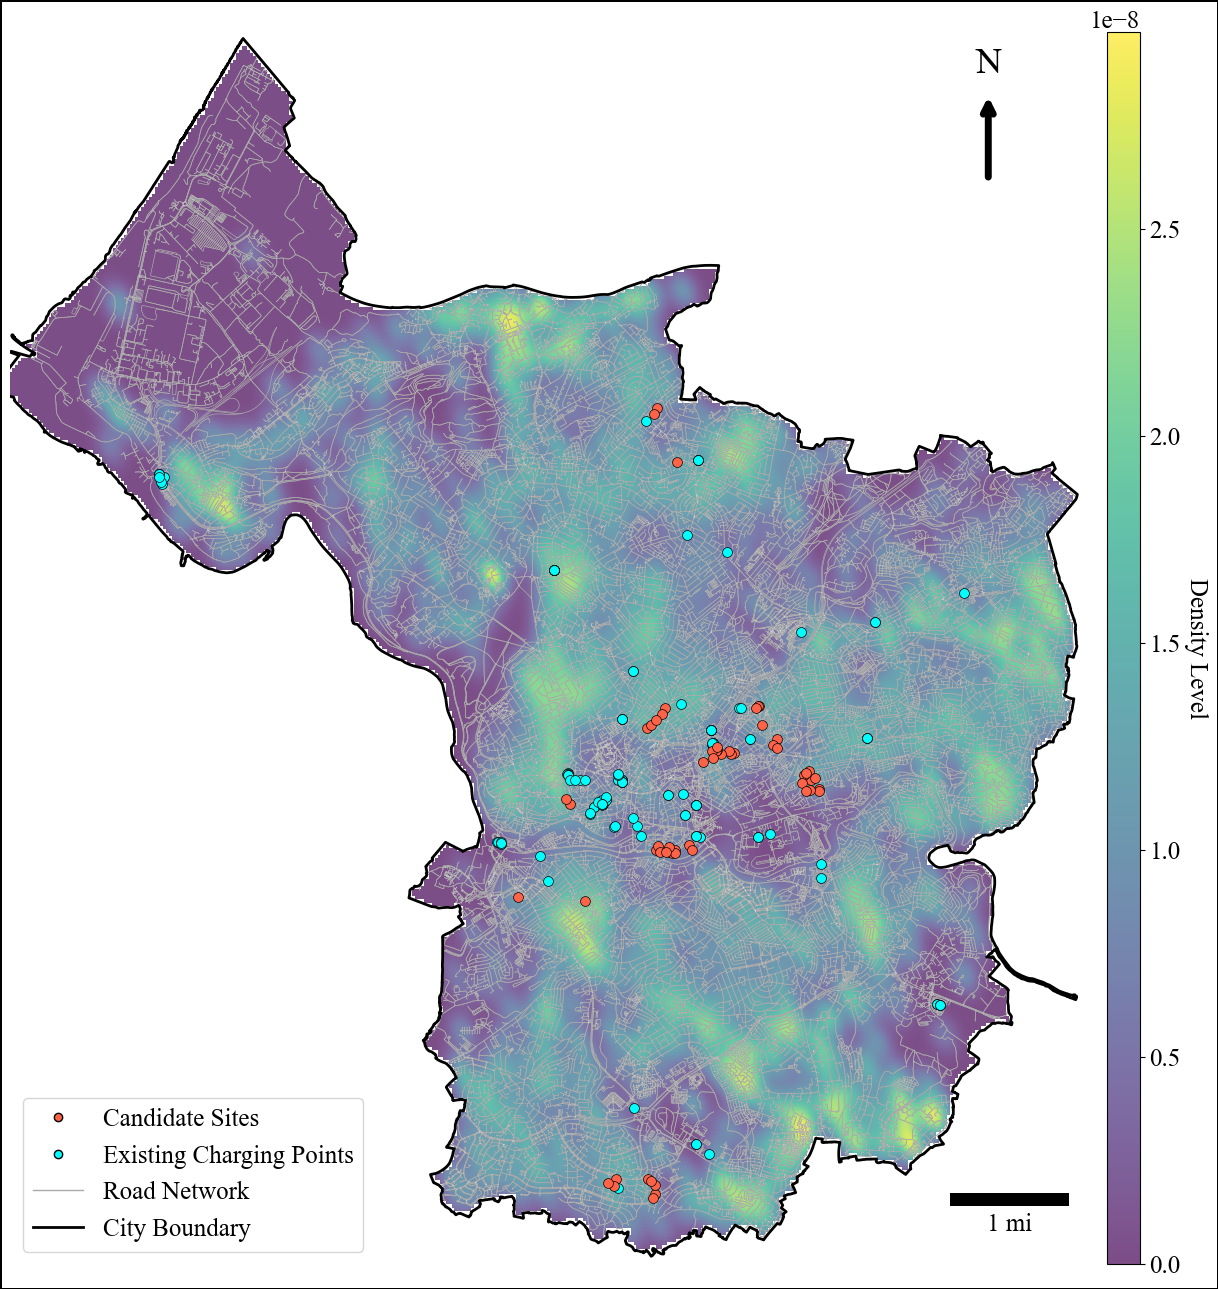

In [ ]:
# Academic font setup
font = {'family': 'Times New Roman', 'size': 18}
plt.rc('font', **font)

# Plotting setup
fig, ax = plt.subplots(figsize=(16, 16))
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(1)

# Plot road network
ox.plot_graph(
    bristol_road_network,
    ax=ax,
    node_size=0.1,
    edge_color='darkgray',  # Changed for better visualization
    edge_linewidth=0.5,     # Slightly thicker lines for visibility
    bgcolor='#f5f5f5',
    show=False,
    close=False
)

# Plot masked KDE heatmap within boundary
heatmap = ax.imshow(zi_masked, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='viridis', alpha=0.7)

# Colorbar for KDE
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(heatmap, cax=cax, orientation='vertical')
cbar.set_label('Density Level', rotation=270, labelpad=20)

# Plot boundary
boundary.plot(ax=ax, edgecolor='black', linewidth=2.0, facecolor='none')

# Plot charging points with thicker black border
charging_points.plot(ax=ax, color='cyan', markersize=50, label='Existing Charging Points', edgecolor='black', linewidth=0.5)

# Plot candidate points with thicker black border
parking_points.plot(ax=ax, color='tomato', markersize=50, label='Candidate Sites', edgecolor='black', linewidth=0.5)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=6, label='Candidate Sites', markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=6, label='Existing Charging Points', markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], color='darkgray', lw=1.0, label='Road Network'),
    Line2D([0], [0], color='black', lw=2.0, label='City Boundary')
]
ax.legend(handles=legend_elements, loc='lower left')

# Move compass to the right side and make it bigger
ax.annotate('', xy=(0.9, 0.95), xycoords='axes fraction',
            xytext=(0.9, 0.88), textcoords='axes fraction',  # Increase the length of the arrow
            arrowprops=dict(arrowstyle="->", color="black", lw=5))  # Thicker line
ax.text(0.9, 0.96, 'N', ha='center', va='bottom', fontsize=26, transform=ax.transAxes)  # Larger text

# Add scale bar
scalebar = ScaleBar(
    dx=1/1609.34,  # Convert meters to miles
    units='mi',  # Set units to miles
    dimension="imperial-length",
    length_fraction=0.2,
    scale_formatter=lambda value, unit: f'{value:.0f} mi',
    location='lower right',
    pad=1.0
)
ax.add_artist(scalebar)

# Show the plot
plt.show()

# Generate Distance Matrix

In [ ]:
# Reset indices and assign 'area_id' to pop
pop = pop.reset_index(drop=True)
pop['area_id'] = pop.index

In [ ]:
# Reset indices and assign 'station_id' and 'destination_id' to charging_points
charging_points = charging_points.reset_index(drop=True)
charging_points['station_id'] = charging_points.index
charging_points['destination_id'] = charging_points['station_id']  # destination_id matches station_id

# Reset indices and assign 'candidate_id' and 'destination_id' to parking_points
parking_points = parking_points.reset_index(drop=True)
parking_points['candidate_id'] = parking_points.index
parking_points['destination_id'] = parking_points['candidate_id'] + len(charging_points)

# Set 'destination_id' as the index
charging_points.set_index('destination_id', inplace=True)
parking_points.set_index('destination_id', inplace=True)

In [ ]:
# Ensure the graph is undirected and add edge lengths
G = bristol_road_network.to_undirected()
for u, v, data in G.edges(data=True):
    if 'geometry' in data:
        data['length'] = data['geometry'].length
    else:
        point_u = Point((G.nodes[u]['x'], G.nodes[u]['y']))
        point_v = Point((G.nodes[v]['x'], G.nodes[v]['y']))
        data['length'] = point_u.distance(point_v)

In [ ]:
# Get centroids of population areas
pop['centroid'] = pop.geometry.centroid

# Extract coordinates function
def get_coords(geometry_series):
    return [(geom.x, geom.y) for geom in geometry_series]

# Get coordinates
orig_coords = get_coords(pop['centroid'])
charging_coords = get_coords(charging_points['geometry'])
candidate_coords = get_coords(parking_points['geometry'])

# Combine charging and candidate sites for destinations
dest_coords = charging_coords + candidate_coords

In [ ]:
# Get nearest nodes for origins (population) and destinations (stations/candidates)
orig_nodes = ox.nearest_nodes(G, [coord[0] for coord in orig_coords], [coord[1] for coord in orig_coords])
dest_nodes = ox.nearest_nodes(G, [coord[0] for coord in dest_coords], [coord[1] for coord in dest_coords])

In [ ]:
# DataFrames for origins
origins_df = pd.DataFrame({'area_id': pop['area_id'], 'node': orig_nodes})

# Create destinations_df
destinations_df = pd.DataFrame({
    'destination_id': list(charging_points.index) + list(parking_points.index),
    'node': dest_nodes,
    'type': ['station'] * len(charging_points) + ['candidate'] * len(parking_points)
})
destinations_df.set_index('destination_id', inplace=True)

### Dijkstra

In [ ]:
# Dijkstra’s Algorithm Calculation
distance_data_dijkstra = []
start_time = time.time()

for i, origin in tqdm(origins_df.iterrows(), total=origins_df.shape[0], desc="Calculating Dijkstra distances"):
    origin_node = origin['node']
    lengths = nx.single_source_dijkstra_path_length(G, origin_node, weight='length')
    for destination_id, destination in destinations_df.iterrows():
        dest_node = destination['node']
        length = lengths.get(dest_node, np.inf)
        distance_data_dijkstra.append({
            'area_id': origin['area_id'],
            'destination_id': destination_id,
            'type': destination['type'],
            'distance': length
        })

dijkstra_time = time.time() - start_time
print(f"Dijkstra's algorithm running time: {dijkstra_time:.2f} seconds")

# Create DataFrame
distance_matrix_dijkstra = pd.DataFrame(distance_data_dijkstra)

Calculating Dijkstra distances: 100%|██████████████████████████████████████████████| 1405/1405 [04:10<00:00,  5.61it/s]


Dijkstra's algorithm running time: 250.62 seconds


In [ ]:
distance_matrix_dijkstra

area_id  destination_id       type     distance
0             0               0    station  1322.544571
1             0               1    station   893.931013
2             0               2    station  2667.227585
3             0               3    station  3311.083694
4             0               4    station  2736.447421
...         ...             ...        ...          ...
255705     1404             177  candidate  5650.651375
255706     1404             178  candidate  5688.625518
255707     1404             179  candidate  5578.907261
255708     1404             180  candidate  5175.532869
255709     1404             181  candidate  4877.883980

[255710 rows x 4 columns]

### A*

In [ ]:
# A* Algorithm Calculation
distance_data_astar = []
start_time = time.time()

# Precompute node coordinates
node_coords = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

def euclidean_distance(u, v):
    """Fast Euclidean distance without creating Point objects."""
    ux, uy = node_coords[u]
    vx, vy = node_coords[v]
    dx = ux - vx
    dy = uy - vy
    return math.hypot(dx, dy)

for i, origin in tqdm(origins_df.iterrows(), total=origins_df.shape[0], desc="Calculating A* distances"):
    origin_node = origin['node']
    for destination_id, destination in destinations_df.iterrows():
        dest_node = destination['node']
        try:
            length = nx.astar_path_length(G, origin_node, dest_node, heuristic=euclidean_distance, weight='length')
        except nx.NetworkXNoPath:
            length = np.inf
        distance_data_astar.append({
            'area_id': origin['area_id'],
            'destination_id': destination_id,
            'type': destination['type'],
            'distance': length
        })

astar_time = time.time() - start_time
print(f"A* algorithm running time: {astar_time:.2f} seconds")

# Create DataFrame
distance_matrix_astar = pd.DataFrame(distance_data_astar)

Calculating A* distances: 100%|██████████████████████████████████████████████████| 1405/1405 [2:02:52<00:00,  5.25s/it]


A* algorithm running time: 7372.89 seconds


In [ ]:
distance_matrix_astar

area_id  destination_id       type     distance
0             0               0    station  1322.544571
1             0               1    station   893.931013
2             0               2    station  2667.227585
3             0               3    station  3311.083694
4             0               4    station  2736.447421
...         ...             ...        ...          ...
255705     1404             177  candidate  5650.651375
255706     1404             178  candidate  5688.625518
255707     1404             179  candidate  5578.907261
255708     1404             180  candidate  5175.532869
255709     1404             181  candidate  4877.883980

[255710 rows x 4 columns]

### XGBoost

In [ ]:
start_time = time.time()

# Sample 30% of the Dijkstra distances for training
distance_sample = distance_matrix_dijkstra[distance_matrix_dijkstra['distance'] != np.inf].sample(frac=0.3, random_state=42)

# Euclidean distance calculation function
def calculate_euclidean_distance(row):
    origin_geom = pop.loc[pop['area_id'] == row['area_id'], 'centroid'].values[0]
    if row['type'] == 'station':
        dest_geom = charging_points.loc[row['destination_id'], 'geometry']
    else:
        dest_geom = parking_points.loc[row['destination_id'], 'geometry']
    return origin_geom.distance(dest_geom)

distance_sample['euclidean_distance'] = distance_sample.apply(calculate_euclidean_distance, axis=1)

In [ ]:
# Prepare features and target
X = distance_sample[['euclidean_distance']]
y = distance_sample['distance']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

xgb_training_time = time.time() - start_time
print(f"XGBoost training time with 30% sample: {xgb_training_time:.2f} seconds")

XGBoost training time with 30% sample: 20.22 seconds


In [ ]:
# Start timing for prediction
start_time = time.time()

# Prepare all data for prediction
tqdm.pandas()  # Enable tqdm for pandas
all_pairs = pd.merge(origins_df, destinations_df.reset_index(), how='cross')
all_pairs['euclidean_distance'] = all_pairs.progress_apply(calculate_euclidean_distance, axis=1)

# Predict distances
all_pairs['distance'] = xgb_model.predict(all_pairs[['euclidean_distance']])

xgb_prediction_time = time.time() - start_time
print(f"XGBoost prediction time: {xgb_prediction_time:.2f} seconds")

# Total time for XGBoost
xgb_total_time = xgb_training_time + xgb_prediction_time
print(f"XGBoost total running time: {xgb_total_time:.2f} seconds")

# Create DataFrame
distance_matrix_xgb = all_pairs[['area_id', 'destination_id', 'type', 'distance']]

100%|████████████████████████████████████████████████████████████████████████| 255710/255710 [01:10<00:00, 3634.47it/s]

XGBoost prediction time: 70.45 seconds
XGBoost total running time: 90.67 seconds


In [ ]:
distance_matrix_xgb

area_id  destination_id       type     distance
0             0               0    station  1486.674316
1             0               1    station   820.023499
2             0               2    station  2889.416992
3             0               3    station  3466.488525
4             0               4    station  2918.072021
...         ...             ...        ...          ...
255705     1404             177  candidate  5125.008789
255706     1404             178  candidate  5211.228027
255707     1404             179  candidate  5125.008789
255708     1404             180  candidate  5121.186035
255709     1404             181  candidate  4623.767090

[255710 rows x 4 columns]

In [ ]:
# Merge the results for error calculation with explicit suffixes
distance_comparison = distance_matrix_dijkstra[['area_id', 'destination_id', 'distance']].rename(columns={'distance': 'distance_dijkstra'})
distance_comparison = distance_comparison.merge(
    distance_matrix_astar[['area_id', 'destination_id', 'distance']].rename(columns={'distance': 'distance_astar'}),
    on=['area_id', 'destination_id'], how='left'
)
distance_comparison = distance_comparison.merge(
    distance_matrix_xgb[['area_id', 'destination_id', 'distance']].rename(columns={'distance': 'distance_xgb'}),
    on=['area_id', 'destination_id'], how='left'
)

# Calculate Mean Absolute Errors (MAE)
mae_astar = mean_absolute_error(distance_comparison['distance_dijkstra'], distance_comparison['distance_astar'])
mae_xgb = mean_absolute_error(distance_comparison['distance_dijkstra'], distance_comparison['distance_xgb'])

# Calculate XGBoost total time with 20% of Dijkstra's time added
xgb_total_time = (0.3 * dijkstra_time) + xgb_training_time + xgb_prediction_time
print(f"Adjusted XGBoost total running time: {xgb_total_time:.2f} seconds")

# Create summary DataFrame with updated XGBoost time
summary_df = pd.DataFrame({
    'Algorithm': ['Dijkstra', 'A*', 'XGBoost'],
    'Running Time (seconds)': [dijkstra_time, astar_time, xgb_total_time],
    'Mean Absolute Error (compared to Dijkstra)': [0, mae_astar, mae_xgb]  # Dijkstra is the reference, so error is 0
})

# Print the summary DataFrame
summary_df

Adjusted XGBoost total running time: 165.85 seconds


Algorithm  Running Time (seconds)  \
0  Dijkstra              250.618996   
1        A*             7372.886316   
2   XGBoost              165.853921   

   Mean Absolute Error (compared to Dijkstra)  
0                                    0.000000  
1                                    0.000000  
2                                  204.910337

In [ ]:
# Save distance matrices for later use
distance_matrix_dijkstra.to_csv('results/distance_matrix_dijkstra.csv', index=False)
distance_matrix_astar.to_csv('results/distance_matrix_astar.csv', index=False)
distance_matrix_xgb.to_csv('results/distance_matrix_xgb.csv', index=False)

In [ ]:
# distance_matrix_dijkstra = pd.read_csv('results/distance_matrix_dijkstra.csv')
# distance_matrix_astar = pd.read_csv('results/distance_matrix_astar.csv')
# distance_matrix_xgb = pd.read_csv('results/distance_matrix_xgb.csv')

## Visualization

In [ ]:
# Combine data into one DataFrame with a new column to indicate the source.
distance_matrix_dijkstra['algorithm'] = 'Dijkstra'
distance_matrix_astar['algorithm'] = 'A*'
distance_matrix_xgb['algorithm'] = 'XGB'

combined_df = pd.concat([distance_matrix_dijkstra, distance_matrix_astar, distance_matrix_xgb])

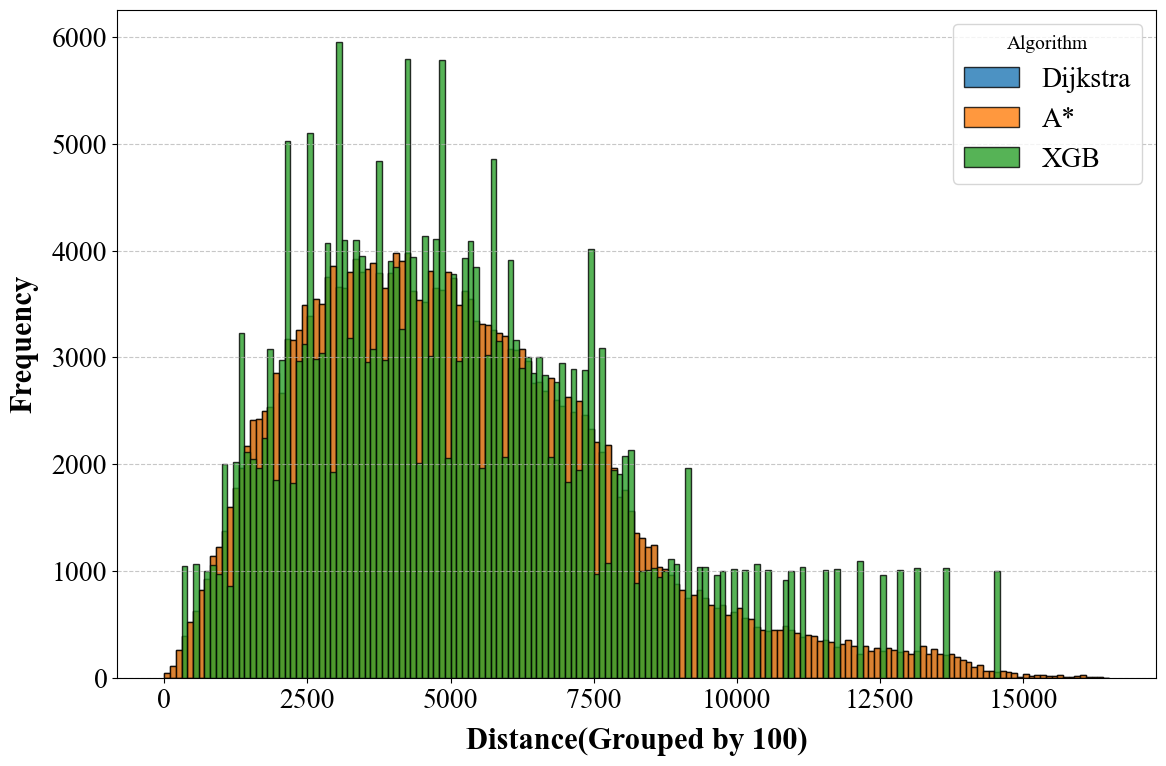

In [ ]:
# Determining dynamic bins for better presentation based on the range and distribution of distances
bin_width = 100  # Setting a bin width to create meaningful groupings
bins = range(0, int(combined_df['distance'].max()) + bin_width, bin_width)

# Redefining the color and hatching styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plotting with the corrected definitions and refined style
plt.figure(figsize=(12, 8))

# Loop through each algorithm and color
for algo, color in zip(combined_df['algorithm'].unique(), colors):
    distances = combined_df[combined_df['algorithm'] == algo]['distance']
    plt.hist(distances, bins=bins, alpha=0.8, label=algo, color=color, edgecolor='black')

# Update title and axis labels to reflect bin adjustments
plt.xlabel('Distance(Grouped by 100)', fontsize=22, labelpad=10, weight="bold")
plt.ylabel('Frequency', fontsize=22, labelpad=10, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title='Algorithm', fontsize=20, title_fontsize=14, loc='upper right', frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a tight layout for better spacing
plt.tight_layout()

plt.show()

## AHP Analysis for Candidate Site Selection

In [ ]:
# Filter distance matrices for candidate sites only
candidate_distances_dijkstra = distance_matrix_dijkstra[distance_matrix_dijkstra['type'] == 'candidate']
candidate_distances_astar = distance_matrix_astar[distance_matrix_astar['type'] == 'candidate']
candidate_distances_xgb = distance_matrix_xgb[distance_matrix_xgb['type'] == 'candidate']

In [ ]:
# Calculate the number of charging points to adjust candidate_id
num_charging_points = len(charging_points)

# Add 'candidate_id' to candidate distances using .loc to avoid SettingWithCopyWarning
for df in [candidate_distances_dijkstra, candidate_distances_astar, candidate_distances_xgb]:
    df.loc[:, 'candidate_id'] = df['destination_id'] - num_charging_points

C:\Users\Sigao Li\AppData\Local\Temp\ipykernel_25852\244924412.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'candidate_id'] = df['destination_id'] - num_charging_points
C:\Users\Sigao Li\AppData\Local\Temp\ipykernel_25852\244924412.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'candidate_id'] = df['destination_id'] - num_charging_points
C:\Users\Sigao Li\AppData\Local\Temp\ipykernel_25852\244924412.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [ ]:
# Prepare population data for merging
pop_subset = pop[['area_id', 'ev_commute_charger']].copy()

In [ ]:
def calculate_weighted_distance(candidate_distances):
    # Merge with population data to get 'ev_commute_charger'
    candidate_distances = candidate_distances.merge(pop_subset, on='area_id', how='left')

    # Calculate weighted distances, excluding 'candidate_id' from the calculation explicitly
    weighted_distances = candidate_distances.groupby('candidate_id').apply(
        lambda x: np.average(x['distance'], weights=x['ev_commute_charger'])
    ).reset_index(name='weighted_distance')

    return weighted_distances

# Calculate weighted distances for each algorithm
weighted_distances_dijkstra = calculate_weighted_distance(candidate_distances_dijkstra)
weighted_distances_astar = calculate_weighted_distance(candidate_distances_astar)
weighted_distances_xgb = calculate_weighted_distance(candidate_distances_xgb)

C:\Users\Sigao Li\AppData\Local\Temp\ipykernel_25852\1841372200.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_distances = candidate_distances.groupby('candidate_id').apply(
C:\Users\Sigao Li\AppData\Local\Temp\ipykernel_25852\1841372200.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_distances = candidate_distances.groupby('candidate_id').apply(
C:\Users\Sigao Li\AppData\Local\Te

In [ ]:
def calculate_proximity_score(candidate_sites, pop, buffer_distance=1609.34):
    # Ensure no conflicting column names in candidate_sites and pop
    for df in [candidate_sites, pop]:
        if 'index_left' in df.columns or 'index_right' in df.columns:
            df.rename(columns={'index_left': 'left_idx_old', 'index_right': 'right_idx_old'}, inplace=True)

    # Buffer candidate sites by the given distance
    candidate_sites_buffered = candidate_sites.copy()
    candidate_sites_buffered['geometry'] = candidate_sites_buffered['geometry'].buffer(buffer_distance)

    # Perform spatial join with EV commute chargers
    joined = gpd.sjoin(
        candidate_sites_buffered,
        pop[['geometry', 'ev_commute_charger']],
        how='left',
        predicate='intersects'
    )

    # Aggregate scores by candidate site
    proximity_scores = joined.groupby('candidate_id').agg({
        'ev_commute_charger': 'sum'
    }).reset_index()

    # Handle NaN values
    proximity_scores['ev_commute_charger'] = proximity_scores['ev_commute_charger'].fillna(0)

    # Normalize scores
    max_charger_score = proximity_scores['ev_commute_charger'].max()
    if max_charger_score > 0:
        proximity_scores['proximity_score'] = proximity_scores['ev_commute_charger'] / max_charger_score
    else:
        proximity_scores['proximity_score'] = 0  # If no chargers, all scores are zero

    return proximity_scores[['candidate_id', 'proximity_score']]

# Reset indices without adding the old index as a column
parking_points_reset = parking_points.reset_index(drop=True)
pop_reset = pop.reset_index(drop=True)

# Calculate proximity scores using EV commute chargers
proximity_scores = calculate_proximity_score(parking_points_reset, pop_reset)

C:\Users\Sigao Li\AppData\Local\Temp\ipykernel_25852\314792054.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  proximity_scores['ev_commute_charger'] = proximity_scores['ev_commute_charger'].fillna(0)


In [ ]:
def calculate_expansion_potential(candidate_sites, pop):
    # Ensure no conflicting column names in candidate_sites and pop
    for df in [candidate_sites, pop]:
        if 'index_left' in df.columns or 'index_right' in df.columns:
            df.rename(columns={'index_left': 'left_idx_old', 'index_right': 'right_idx_old'}, inplace=True)

    # Set buffer distance to 1 mile (1 mile ≈ 1609.34 meters)
    buffer_distance = 1609.34

    # Buffer candidate sites by 1 mile
    candidate_sites_buffered = candidate_sites.copy()
    candidate_sites_buffered['geometry'] = candidate_sites_buffered['geometry'].buffer(buffer_distance)

    # Spatial join with population data
    joined = gpd.sjoin(
        candidate_sites_buffered,
        pop[['geometry', 'age_16_29', 'age_30_49']],
        how='left',
        predicate='intersects'
    )

    # Sum the younger population groups
    expansion_potential = joined.groupby('candidate_id').agg({
        'age_16_29': 'sum',
        'age_30_49': 'sum'
    }).reset_index()

    # Total young population
    expansion_potential['young_population'] = expansion_potential[['age_16_29', 'age_30_49']].sum(axis=1)

    # Handle NaN values
    expansion_potential['young_population'] = expansion_potential['young_population'].fillna(0)

    # Normalize scores
    max_population = expansion_potential['young_population'].max()
    expansion_potential['expansion_score'] = expansion_potential['young_population'] / max_population

    return expansion_potential[['candidate_id', 'expansion_score']]

# Reset indices without adding the old index as a column
parking_points_reset = parking_points.reset_index(drop=True)
pop_reset = pop.reset_index(drop=True)

# Calculate expansion potential scores
expansion_scores = calculate_expansion_potential(parking_points_reset, pop_reset)

C:\Users\Sigao Li\AppData\Local\Temp\ipykernel_25852\1914099269.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  expansion_potential['young_population'] = expansion_potential['young_population'].fillna(0)


In [ ]:
# Load major roads
major_roads = ox.graph_from_place("Bristol, United Kingdom", network_type='drive', custom_filter='["highway"~"motorway|trunk"]')
major_roads = ox.project_graph(major_roads, to_crs=pop.crs)

# Convert major roads to GeoDataFrame
edges = ox.graph_to_gdfs(major_roads, nodes=False, edges=True)

def calculate_commuting_convenience(candidate_sites):
    # Calculate nearest distance to major roads
    candidate_sites['nearest_road_distance'] = candidate_sites['geometry'].apply(
        lambda geom: edges.distance(geom).min()
    )

    # Normalize distances to scores (closer to roads has higher score)
    max_distance = candidate_sites['nearest_road_distance'].max()
    candidate_sites['convenience_score'] = 1 - (candidate_sites['nearest_road_distance'] / max_distance)

    return candidate_sites[['candidate_id', 'convenience_score']]

# Calculate commuting convenience scores
convenience_scores = calculate_commuting_convenience(parking_points.reset_index())

In [ ]:
def calculate_distance_to_existing(candidate_sites):
    # Combine all existing station geometries into a single geometry
    combined_existing_geometry = unary_union(charging_points['geometry'])

    # Calculate distance to the nearest existing charging station
    candidate_sites['distance_to_existing'] = candidate_sites['geometry'].apply(
        lambda geom: geom.distance(combined_existing_geometry)
    )

    # Normalize distances to scores (greater distance results in a higher score)
    max_distance = candidate_sites['distance_to_existing'].max()
    candidate_sites['distance_score'] = candidate_sites['distance_to_existing'] / max_distance

    return candidate_sites[['candidate_id', 'distance_score']]

# Calculate distance scores
distance_scores = calculate_distance_to_existing(parking_points.reset_index())

In [ ]:
def merge_scores_without_weighted(expansion_scores, convenience_scores, distance_scores, proximity_scores):
    # Merge all scores into a single DataFrame
    scores = proximity_scores.merge(expansion_scores, on='candidate_id', how='left')
    scores = scores.merge(convenience_scores, on='candidate_id', how='left')
    scores = scores.merge(distance_scores, on='candidate_id', how='left')
    return scores

# Merge scores for each algorithm
scores_dijkstra = merge_scores_without_weighted(expansion_scores, convenience_scores, distance_scores, proximity_scores)
scores_astar = merge_scores_without_weighted(expansion_scores, convenience_scores, distance_scores, proximity_scores)
scores_xgb = merge_scores_without_weighted(expansion_scores, convenience_scores, distance_scores, proximity_scores)

# Define weights
weights = {
    'proximity_score': 0.35,
    'expansion_score': 0.25,
    'convenience_score': 0.25,
    'distance_score': 0.15
}

def calculate_final_scores(scores):
    # Fill NaN values with zero
    scores = scores.fillna(0)

    # Calculate the weighted final score
    scores['final_score'] = (
        scores['proximity_score'] * weights['proximity_score'] +
        scores['expansion_score'] * weights['expansion_score'] +
        scores['convenience_score'] * weights['convenience_score'] +
        scores['distance_score'] * weights['distance_score']
    )
    return scores

# Apply final score calculation
scores_dijkstra = calculate_final_scores(scores_dijkstra)
scores_astar = calculate_final_scores(scores_astar)
scores_xgb = calculate_final_scores(scores_xgb)

In [ ]:
def select_top_candidates(scores):
    # Sort by final score and select the top 30%
    scores = scores.sort_values(by='final_score', ascending=False)
    top_n = int(len(scores) * 0.3)
    return scores.head(top_n)

# Select top candidates for each algorithm
top_candidates_dijkstra = select_top_candidates(scores_dijkstra)
top_candidates_astar = select_top_candidates(scores_astar)
top_candidates_xgb = select_top_candidates(scores_xgb)

In [ ]:
# Get sets of candidate_ids
set_dijkstra = set(top_candidates_dijkstra['candidate_id'])
set_astar = set(top_candidates_astar['candidate_id'])
set_xgb = set(top_candidates_xgb['candidate_id'])

# Calculate overlaps
overlap_dijkstra_astar = set_dijkstra.intersection(set_astar)
overlap_dijkstra_xgb = set_dijkstra.intersection(set_xgb)
overlap_astar_xgb = set_astar.intersection(set_xgb)

# Print overlap percentages
print(f"Overlap between Dijkstra and A*: {len(overlap_dijkstra_astar) / len(set_dijkstra) * 100:.2f}%")
print(f"Overlap between Dijkstra and XGBoost: {len(overlap_dijkstra_xgb) / len(set_dijkstra) * 100:.2f}%")
print(f"Overlap between A* and XGBoost: {len(overlap_astar_xgb) / len(set_astar) * 100:.2f}%")

Overlap between Dijkstra and A*: 100.00%
Overlap between Dijkstra and XGBoost: 100.00%
Overlap between A* and XGBoost: 100.00%


## Visualization

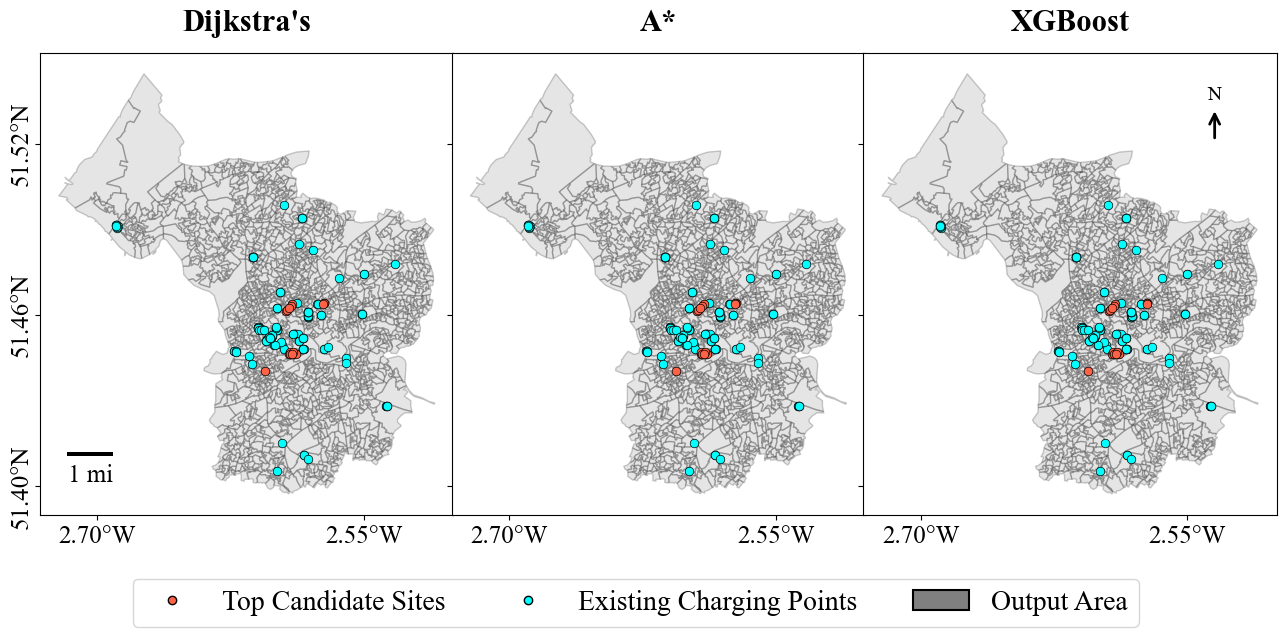

In [ ]:
# Academic font setup
font = {'family': 'Times New Roman', 'size': 18}
plt.rc('font', **font)

def format_coordinates(x, pos):
    """Format coordinates to show as degrees with direction."""
    if x < 0:
        return f"{abs(x):.2f}°W" if pos == 0 else f"{abs(x):.2f}°S"
    else:
        return f"{x:.2f}°E" if pos == 0 else f"{x:.2f}°N"

def plot_top_candidates_academic(top_candidates, algorithm_name, ax, pop, charging_points, parking_points, add_scalebar=False, add_compass=False, hide_y_labels=False, rotate_y_labels=False):
    # Merge with candidate sites GeoDataFrame using candidate_id
    top_sites = parking_points.merge(top_candidates[['candidate_id', 'final_score']], on='candidate_id')

    # Plot base layers
    pop.plot(ax=ax, color='grey', edgecolor='black', alpha=0.2)
    charging_points.plot(ax=ax, color='cyan', markersize=38, edgecolor='black', linewidth=0.5)
    top_sites.plot(ax=ax, color='tomato', markersize=38, edgecolor='black', linewidth=0.5)

    # Add title with increased padding
    ax.set_title(f"{algorithm_name}", fontsize=22, weight='bold', pad=16)

    # Customize axes for coordinate formatting
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_coordinates(x, 0)))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: format_coordinates(y, 1)))

    # Adjust ticks on both axes
    ax.xaxis.set_major_locator(MaxNLocator(nbins=2))  # Two horizontal ticks
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))  # Three vertical ticks

    if hide_y_labels:
        ax.set_yticklabels([])  # Remove Y-axis text but keep ticks and axis line

    if rotate_y_labels:
        for label in ax.get_yticklabels():
            label.set_rotation(90)  # Rotate text
            label.set_ha('center')  # Align horizontally with tick marks
            label.set_va('center')  # Align vertically with tick marks
            label.set_position((-0.02, 0))  # Increase distance from tick marks (adjust the -0.15 value as needed)

    if add_scalebar:
        # Add scale bar
        scalebar = ScaleBar(
            dx=1/1609.34,  # Convert meters to miles
            units='mi',
            dimension="imperial-length",
            length_fraction=0.2,
            scale_formatter=lambda value, unit: f'{value:.0f} mi',
            location='lower left',
            pad=1.0
        )
        ax.add_artist(scalebar)

    if add_compass:
        # Add compass (north arrow) to the slightly adjusted position
        ax.annotate('', xy=(0.85, 0.88), xycoords='axes fraction',  # Adjusted position
                    xytext=(0.85, 0.81), textcoords='axes fraction',  # Adjusted arrow length
                    arrowprops=dict(arrowstyle="->", color="black", lw=2))
        ax.text(0.85, 0.89, 'N', ha='center', va='bottom', fontsize=14, transform=ax.transAxes)

# Convert all GeoDataFrames to EPSG: 4326 (WGS 84)
pop = pop.to_crs(epsg=4326)
charging_points = charging_points.to_crs(epsg=4326)
parking_points = parking_points.to_crs(epsg=4326)

# Create subplots for side-by-side comparison with reduced spacing
fig, axs = plt.subplots(
    1, 3, figsize=(18, 6),
    gridspec_kw={'wspace': -0.28},  # Reduced horizontal space between plots
    constrained_layout=False        # Disable constrained layout for custom spacing
)

# Plot each algorithm's results
plot_top_candidates_academic(top_candidates_dijkstra, "Dijkstra's", axs[0], pop, charging_points, parking_points, add_scalebar=True, rotate_y_labels=True)
plot_top_candidates_academic(top_candidates_astar, "A*", axs[1], pop, charging_points, parking_points, hide_y_labels=True)
plot_top_candidates_academic(top_candidates_xgb, "XGBoost", axs[2], pop, charging_points, parking_points, add_compass=True, hide_y_labels=True)

# Create a single legend at the bottom
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=6,
           label='Top Candidate Sites', markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=6,
           label='Existing Charging Points', markeredgewidth=1, markeredgecolor='black'),
    Patch(facecolor='grey', edgecolor='black', linewidth=1.5, label='Output Area')
]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    fontsize=20,
    ncol=3,
    bbox_to_anchor=(0.5, -0.1)
)

# Show the final figure
plt.show()

## Goal Planning and Demand Allocation

In [ ]:
# Function to Calculate Metrics for Each Candidate Point
def calculate_metrics_for_candidate(distance_matrix, candidate_point, algorithm_name):
    candidate_id = candidate_point['candidate_id'].values[0]
    print(f"\nCalculating metrics for {algorithm_name} with Candidate ID {candidate_id}...\n")

    # **1. Prepare Data**

    ### **1.1 Consolidate Charging Facilities**

    def consolidate_charging_stations(candidate_point):
        existing_stations = charging_points.copy()
        existing_stations['facility_id'] = existing_stations['station_id']
        existing_stations['type'] = 'existing'

        # Include the single candidate site
        candidate_site = parking_points.copy()
        candidate_site = candidate_site[candidate_site['candidate_id'] == candidate_id]

        # Adjust 'facility_id' to ensure uniqueness
        max_station_id = existing_stations['facility_id'].max()
        candidate_site['facility_id'] = candidate_site['candidate_id'] + max_station_id + 1
        candidate_site['type'] = 'candidate'

        facilities = pd.concat([existing_stations, candidate_site], ignore_index=True)
        facilities.set_index('facility_id', inplace=True)

        return facilities

    # Use the single candidate point
    facilities = consolidate_charging_stations(candidate_point)

    ### **1.2 Prepare Distance Matrix**

    def prepare_distance_matrix(distance_matrix, facilities):
        facility_id_mapping = facilities.reset_index()[['facility_id', 'candidate_id']]
        facility_id_mapping = facility_id_mapping.dropna(subset=['candidate_id'])
        candidate_id_to_facility_id = facility_id_mapping.set_index('candidate_id')['facility_id'].to_dict()

        distance_matrix = distance_matrix.copy()
        distance_matrix['facility_id'] = distance_matrix['destination_id']
        distance_matrix['facility_id'] = distance_matrix['facility_id'].replace(candidate_id_to_facility_id)

        facility_ids = facilities.index.tolist()
        distance_matrix_filtered = distance_matrix[distance_matrix['facility_id'].isin(facility_ids)]

        return distance_matrix_filtered

    # Prepare the distance matrix
    distance_matrix = prepare_distance_matrix(distance_matrix, facilities)

    ### **1.3 Prepare Demand Data**

    # Prepare demand data
    pop['demand'] = pop['ev_commute_charger']

    # Create lists for areas and facilities
    areas = pop['area_id'].tolist()
    facility_ids = facilities.index.tolist()

    # Create dictionaries for data
    demand = pop.set_index('area_id')['demand'].to_dict()

    ### **1.4 Create Distance Dictionary**

    # Create distance dictionary
    try:
        distance_dict = distance_matrix.set_index(['area_id', 'facility_id'])['distance'].to_dict()
    except KeyError as e:
        raise KeyError(f"Missing columns in distance_matrix: {e}")

    # Ensure that all distances are positive and not infinite
    distance_dict = {k: v for k, v in distance_dict.items() if np.isfinite(v) and v > 0}

    # Verify that distance_dict is not empty
    if not distance_dict:
        print(f"Distance dictionary is empty for {algorithm_name} with Candidate ID {candidate_id}. Skipping.")
        return None  # Skip further processing for this candidate

    # **2. Define Huff Model Parameters**

    # Define the distance decay parameter
    beta = -1.5  # Negative value indicates inverse relationship

    # Assume equal attractiveness for all facilities
    attractiveness = {facility_id: 1 for facility_id in facility_ids}

    # **3. Calculate Huff Probabilities**

    # Function to calculate Huff probabilities
    def calculate_huff_probabilities(areas, facility_ids, attractiveness, distance_dict, beta):
        probabilities = {}
        for i in areas:
            denominator = 0
            numerator_dict = {}
            # Calculate numerator and denominator for each facility
            for j in facility_ids:
                key = (i, j)
                if key in distance_dict:
                    distance = distance_dict[key]
                    attr = attractiveness[j]
                    numerator = attr * (distance ** beta)
                    numerator_dict[j] = numerator
                    denominator += numerator
                else:
                    numerator_dict[j] = 0
            # Calculate probabilities
            for j in facility_ids:
                if denominator > 0:
                    prob = numerator_dict[j] / denominator
                else:
                    prob = 0
                probabilities[(i, j)] = prob
        return probabilities

    # Calculate Huff probabilities
    probabilities = calculate_huff_probabilities(areas, facility_ids, attractiveness, distance_dict, beta)

    # **4. Calculate Expected Number of Vehicles**

    # Expected number of vehicles from area i to facility j
    expected_vehicles = {}
    for i in areas:
        for j in facility_ids:
            prob = probabilities.get((i, j), 0)
            expected_num = prob * demand[i]
            expected_vehicles[(i, j)] = expected_num

    # **5. Calculate Metrics**

    ### **5.1 Total Path Distance**

    total_path_distance = sum(
        expected_vehicles[(i, j)] * distance_dict.get((i, j), 0)
        for i in areas for j in facility_ids
    )

    ### **5.2 Coverage Percentage**

    # Coverage threshold: 1 mile in meters
    coverage_threshold = 1.0 * 1609.34  # 1 mile = 1609.34 meters

    covered_areas = set()
    for i in areas:
        for j in facility_ids:
            if (i, j) in distance_dict and distance_dict[(i, j)] <= coverage_threshold:
                if expected_vehicles[(i, j)] > 0:
                    covered_areas.add(i)
                    break  # Area is covered, no need to check other facilities

    coverage_percentage = (len(covered_areas) / len(areas)) * 100

    ### **5.3 Median Number of Vehicles Served per Station**

    # Calculate total vehicles allocated to each facility
    facility_utilization = {}
    for j in facility_ids:
        total_allocated = sum(expected_vehicles[(i, j)] for i in areas)
        facility_utilization[j] = total_allocated

    median_vehicles_per_station = np.median(list(facility_utilization.values()))

    # **6. Collect Results**

    results = {
        'Algorithm': algorithm_name,
        'Candidate Site ID': candidate_id,
        'Total Path Distance': total_path_distance,
        'Coverage Percentage': coverage_percentage,
        'Median Vehicles per Station': median_vehicles_per_station
    }

    return results

In [ ]:
# Define the datasets and corresponding top candidates
datasets = [
    ('Dijkstra', distance_matrix_dijkstra, top_candidates_dijkstra),
    ('A*', distance_matrix_astar, top_candidates_astar),
    ('XGBoost', distance_matrix_xgb, top_candidates_xgb)
]

# Initialize a DataFrame to store all results
results_df = pd.DataFrame()

for algorithm_name, distance_matrix, top_candidates in datasets:
    print(f"\nProcessing algorithm: {algorithm_name}")
    candidate_results = []
    # Loop over each candidate point
    for idx, candidate_point in top_candidates.iterrows():
        # Prepare the candidate point as a DataFrame
        candidate_point_df = candidate_point.to_frame().T
        # Calculate metrics for the single candidate point
        result = calculate_metrics_for_candidate(
            distance_matrix, candidate_point_df, algorithm_name
        )
        if result:
            candidate_results.append(result)
        else:
            print(f"No data available for Candidate ID {candidate_point['candidate_id']}.")
    # Create a DataFrame for this algorithm's results
    algorithm_results_df = pd.DataFrame(candidate_results)
    # Append to the main results DataFrame
    results_df = pd.concat([results_df, algorithm_results_df], ignore_index=True)


Processing algorithm: Dijkstra

Calculating metrics for Dijkstra with Candidate ID 29.0...


Calculating metrics for Dijkstra with Candidate ID 27.0...


Calculating metrics for Dijkstra with Candidate ID 26.0...


Calculating metrics for Dijkstra with Candidate ID 28.0...


Calculating metrics for Dijkstra with Candidate ID 25.0...


Calculating metrics for Dijkstra with Candidate ID 38.0...


Calculating metrics for Dijkstra with Candidate ID 55.0...


Calculating metrics for Dijkstra with Candidate ID 37.0...


Calculating metrics for Dijkstra with Candidate ID 34.0...


Calculating metrics for Dijkstra with Candidate ID 33.0...


Calculating metrics for Dijkstra with Candidate ID 57.0...


Calculating metrics for Dijkstra with Candidate ID 12.0...


Calculating metrics for Dijkstra with Candidate ID 54.0...


Calculating metrics for Dijkstra with Candidate ID 13.0...


Calculating metrics for Dijkstra with Candidate ID 53.0...


Calculating metrics for Dijkstra with Candidate ID 3

In [ ]:
# Conversion factor from meters to miles
meters_to_miles = 0.000621371

# Update the Total Path Distance in miles
results_df["Total Path Distance"] = results_df["Total Path Distance"] * meters_to_miles

# Display the updated DataFrame
results_df

Algorithm  Candidate Site ID  Total Path Distance  Coverage Percentage  \
0   Dijkstra               29.0          3543.211705            69.893238   
1   Dijkstra               27.0          3545.996703            69.893238   
2   Dijkstra               26.0          3568.503525            68.683274   
3   Dijkstra               28.0          3543.133089            69.893238   
4   Dijkstra               25.0          3552.252893            69.893238   
5   Dijkstra               38.0          3547.797504            70.320285   
6   Dijkstra               55.0          3545.159775            69.822064   
7   Dijkstra               37.0          3541.899130            70.320285   
8   Dijkstra               34.0          3546.307426            70.320285   
9   Dijkstra               33.0          3541.161508            70.391459   
10  Dijkstra               57.0          3537.028432            70.889680   
11  Dijkstra               12.0          3547.253578            69.893238   
12  Dijkstra               54.0          3540.916232            70.177936   
13  Dijkstra               13.0          3544.806203            69.750890   
14  Dijkstra               53.0          3541.836235            70.249110   
15  Dijkstra               35.0          3546.604131            70.391459   
16  Dijkstra               11.0          3541.412713            69.893238   
17        A*               29.0          3543.211705            69.893238   
18        A*               27.0          3545.996703            69.893238   
19        A*               26.0          3568.503525            68.683274   
20        A*               28.0          3543.133089            69.893238   
21        A*               25.0          3552.252893            69.893238   
22        A*               38.0          3547.797504            70.320285   
23        A*               55.0          3545.159775            69.822064   
24        A*               37.0          3541.899130            70.320285   
25        A*               34.0          3546.307426            70.320285   
26        A*               33.0          3541.161508            70.391459   
27        A*               57.0          3537.028432            70.889680   
28        A*               12.0          3547.253578            69.893238   
29        A*               54.0          3540.916232            70.177936   
30        A*               13.0          3544.806203            69.750890   
31        A*               53.0          3541.836235            70.249110   
32        A*               35.0          3546.604131            70.391459   
33        A*               11.0          3541.412713            69.893238   
34   XGBoost               29.0          3521.620861            70.747331   
35   XGBoost               27.0          3523.624929            70.747331   
36   XGBoost               26.0          3543.978658            69.750890   
37   XGBoost               28.0          3521.406928            70.747331   
38   XGBoost               25.0          3533.793221            70.747331   
39   XGBoost               38.0          3526.426129            71.103203   
40   XGBoost               55.0          3523.366913            70.177936   
41   XGBoost               37.0          3521.173411            70.960854   
42   XGBoost               34.0          3528.353399            71.032028   
43   XGBoost               33.0          3520.826539            71.103203   
44   XGBoost               57.0          3517.611492            71.743772   
45   XGBoost               12.0          3526.963628            70.747331   
46   XGBoost               54.0          3520.369216            71.032028   
47   XGBoost               13.0          3521.517971            70.747331   
48   XGBoost               53.0          3520.716530            71.103203   
49   XGBoost               35.0          3528.058379            71.103203   
50   XGBoost               11.0          3519.902116            70.747331   

In [ ]:
# **1. Divide into three DataFrames by algorithm name**
dijkstra_df = results_df[results_df['Algorithm'] == 'Dijkstra'].copy()
astar_df = results_df[results_df['Algorithm'] == 'A*'].copy()
xgboost_df = results_df[results_df['Algorithm'] == 'XGBoost'].copy()

# Function to calculate rankings for a DataFrame
def calculate_rankings(df):
    # Calculate rankings
    df['Rank_Total_Path_Distance'] = df['Total Path Distance'].rank(ascending=True).astype(int)
    df['Rank_Coverage_Percentage'] = df['Coverage Percentage'].rank(ascending=False).astype(int)
    df['Rank_Median_Vehicles'] = df['Median Vehicles per Station'].rank(ascending=True).astype(int)
    return df

# **2. Calculate rankings for each DataFrame**
dijkstra_df = calculate_rankings(dijkstra_df)
astar_df = calculate_rankings(astar_df)
xgboost_df = calculate_rankings(xgboost_df)

# **3. Sort each DataFrame by Total Path Distance**
dijkstra_df = dijkstra_df.sort_values(by='Total Path Distance', ascending=True).reset_index(drop=True)
astar_df = astar_df.sort_values(by='Total Path Distance', ascending=True).reset_index(drop=True)
xgboost_df = xgboost_df.sort_values(by='Total Path Distance', ascending=True).reset_index(drop=True)

In [ ]:
dijkstra_df.head()

Algorithm  Candidate Site ID  Total Path Distance  Coverage Percentage  \
0  Dijkstra               57.0          3537.028432            70.889680   
1  Dijkstra               54.0          3540.916232            70.177936   
2  Dijkstra               33.0          3541.161508            70.391459   
3  Dijkstra               11.0          3541.412713            69.893238   
4  Dijkstra               53.0          3541.836235            70.249110   

   Median Vehicles per Station  Rank_Total_Path_Distance  \
0                    10.971190                         1   
1                    10.971383                         2   
2                    10.982477                         3   
3                    10.942926                         4   
4                    10.976504                         5   

   Rank_Coverage_Percentage  Rank_Median_Vehicles  
0                         1                     7  
1                         8                     8  
2                         2                    14  
3                        11                     2  
4                         7                    10

In [ ]:
astar_df.head()

Algorithm  Candidate Site ID  Total Path Distance  Coverage Percentage  \
0        A*               57.0          3537.028432            70.889680   
1        A*               54.0          3540.916232            70.177936   
2        A*               33.0          3541.161508            70.391459   
3        A*               11.0          3541.412713            69.893238   
4        A*               53.0          3541.836235            70.249110   

   Median Vehicles per Station  Rank_Total_Path_Distance  \
0                    10.971190                         1   
1                    10.971383                         2   
2                    10.982477                         3   
3                    10.942926                         4   
4                    10.976504                         5   

   Rank_Coverage_Percentage  Rank_Median_Vehicles  
0                         1                     7  
1                         8                     8  
2                         2                    14  
3                        11                     2  
4                         7                    10

In [ ]:
xgboost_df.head()

Algorithm  Candidate Site ID  Total Path Distance  Coverage Percentage  \
0   XGBoost               57.0          3517.611492            71.743772   
1   XGBoost               11.0          3519.902116            70.747331   
2   XGBoost               54.0          3520.369216            71.032028   
3   XGBoost               53.0          3520.716530            71.103203   
4   XGBoost               33.0          3520.826539            71.103203   

   Median Vehicles per Station  Rank_Total_Path_Distance  \
0                    10.631477                         1   
1                    10.649966                         2   
2                    10.624232                         3   
3                    10.631949                         4   
4                    10.625604                         5   

   Rank_Coverage_Percentage  Rank_Median_Vehicles  
0                         1                     4  
1                        12                     8  
2                         6                     2  
3                         3                     5  
4                         3                     3

In [ ]:
# Save distance matrices for later use
dijkstra_df.to_csv('results/result_dijkstra.csv', index=False)
astar_df.to_csv('results/result_astar.csv', index=False)
xgboost_df.to_csv('results/result_xgb.csv', index=False)

In [ ]:
# dijkstra_df = pd.read_csv('results/result_dijkstra.csv')
# astar_df = pd.read_csv('results/result_astar.csv')
# xgboost_df = pd.read_csv('results/result_xgb.csv')

## Visualization

In [ ]:
# Convert all GeoDataFrames to the same CRS (EPSG:27700)
crs_epsg27700 = 'EPSG:27700'
datasets = [pop, charging_points, parking_points, life_style, boundary]
for dataset in datasets:
    if dataset.crs != crs_epsg27700:
        dataset.to_crs(crs_epsg27700, inplace=True)

In [ ]:
# Extract the first Candidate Site ID from each DataFrame
first_candidate_id_dijkstra = dijkstra_df.iloc[0]['Candidate Site ID']
# first_candidate_id_astar = astar_df.iloc[0]['Candidate Site ID']
# first_candidate_id_xgboost = xgboost_df.iloc[0]['Candidate Site ID']

# Filter the parking_points DataFrame
filtered_parking_points_dijkstra = parking_points[parking_points['candidate_id'] == first_candidate_id_dijkstra]
# filtered_parking_points_astar = parking_points[parking_points['candidate_id'] == first_candidate_id_astar]
# filtered_parking_points_xgboost = parking_points[parking_points['candidate_id'] == first_candidate_id_xgboost]

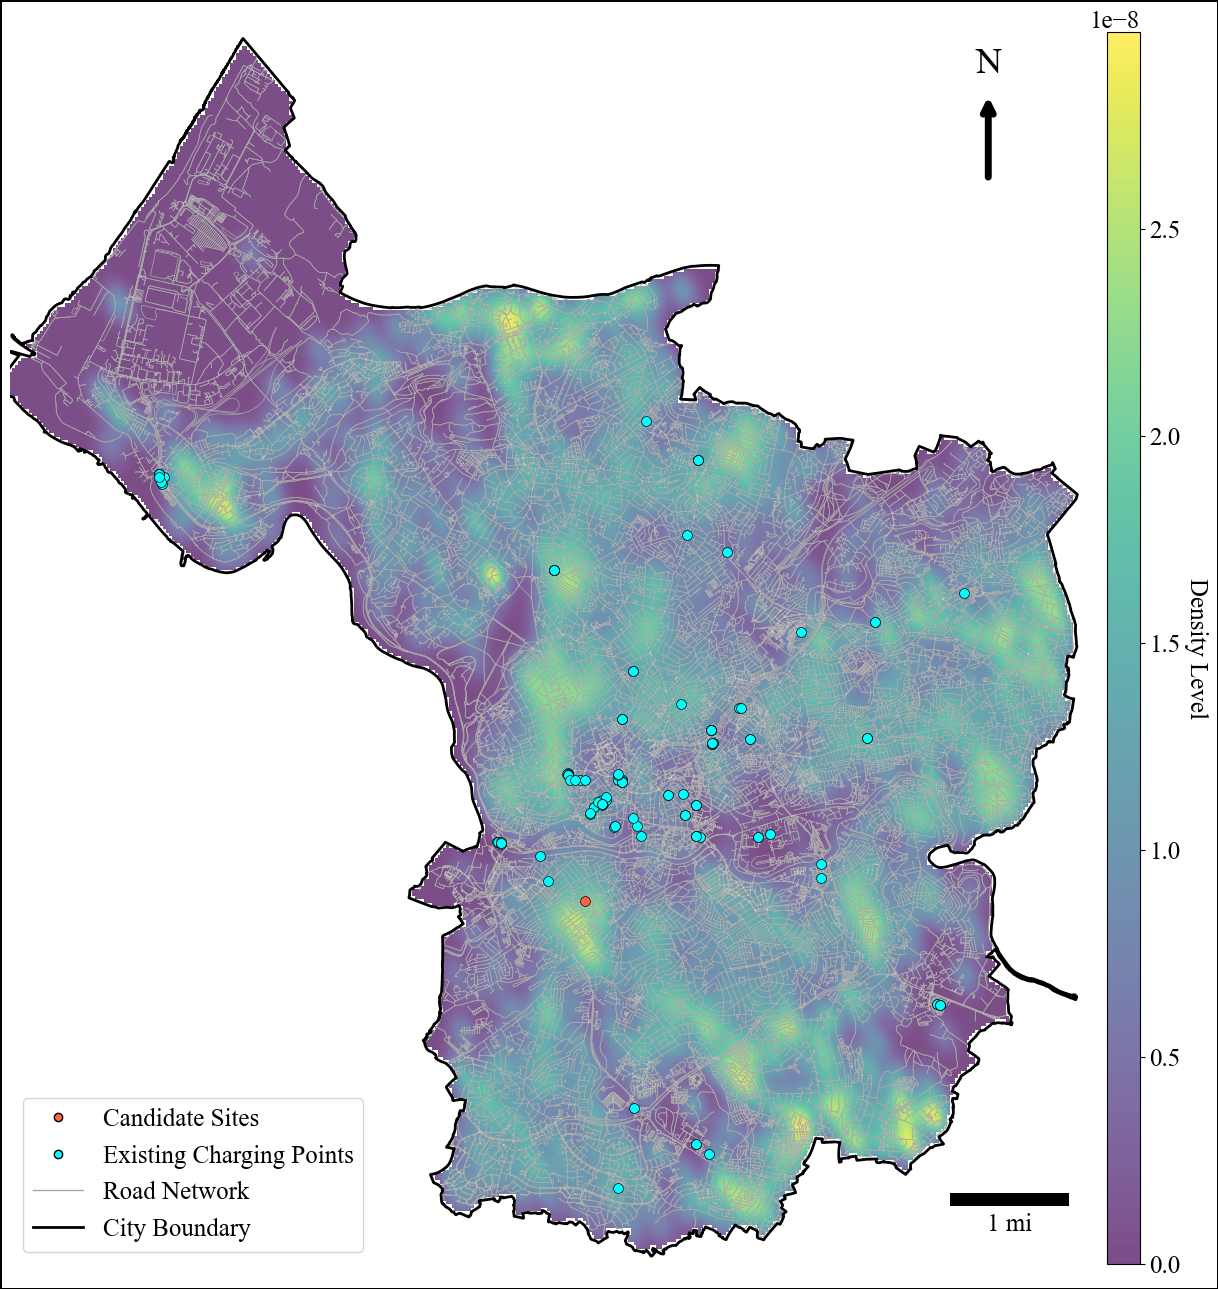

In [ ]:
# Academic font setup
font = {'family': 'Times New Roman', 'size': 18}
plt.rc('font', **font)

# Plotting setup
fig, ax = plt.subplots(figsize=(16, 16))
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(1)

# Plot road network
ox.plot_graph(
    bristol_road_network,
    ax=ax,
    node_size=0.1,
    edge_color='darkgray',  # Changed for better visualization
    edge_linewidth=0.5,     # Slightly thicker lines for visibility
    bgcolor='#f5f5f5',
    show=False,
    close=False
)

# Plot masked KDE heatmap within boundary
heatmap = ax.imshow(zi_masked, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='viridis', alpha=0.7)

# Colorbar for KDE
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(heatmap, cax=cax, orientation='vertical')
cbar.set_label('Density Level', rotation=270, labelpad=20)

# Plot boundary
boundary.plot(ax=ax, edgecolor='black', linewidth=2.0, facecolor='none')

# Plot charging points with thicker black border
charging_points.plot(ax=ax, color='cyan', markersize=50, label='Existing Charging Points', edgecolor='black', linewidth=0.5)

# Plot candidate points with thicker black border
filtered_parking_points.plot(ax=ax, color='tomato', markersize=50, label='Selected Sites', edgecolor='black', linewidth=0.5)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=6, label='Candidate Sites', markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=6, label='Existing Charging Points', markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], color='darkgray', lw=1.0, label='Road Network'),
    Line2D([0], [0], color='black', lw=2.0, label='City Boundary')
]
ax.legend(handles=legend_elements, loc='lower left')

# Move compass to the right side and make it bigger
ax.annotate('', xy=(0.9, 0.95), xycoords='axes fraction',
            xytext=(0.9, 0.88), textcoords='axes fraction',  # Increase the length of the arrow
            arrowprops=dict(arrowstyle="->", color="black", lw=5))  # Thicker line
ax.text(0.9, 0.96, 'N', ha='center', va='bottom', fontsize=26, transform=ax.transAxes)  # Larger text

# Add scale bar
scalebar = ScaleBar(
    dx=1/1609.34,  # Convert meters to miles
    units='mi',  # Set units to miles
    dimension="imperial-length",
    length_fraction=0.2,
    scale_formatter=lambda value, unit: f'{value:.0f} mi',
    location='lower right',
    pad=1.0
)
ax.add_artist(scalebar)

# Show the plot
plt.show()

## Sensitivity Analysis

In [ ]:
def calculate_metrics_with_sensitivity(distance_matrix, candidate_point, algorithm_name, beta, demand_scale):
    candidate_id = candidate_point['candidate_id'].values[0]
    print(f"\nCalculating metrics for {algorithm_name} with Candidate ID {candidate_id} using beta={beta}...\n")

    # **1. Prepare Data**
    def consolidate_charging_stations(candidate_point):
        existing_stations = charging_points.copy()
        existing_stations['facility_id'] = existing_stations['station_id']
        existing_stations['type'] = 'existing'
        candidate_site = parking_points.copy()
        candidate_site = candidate_site[candidate_site['candidate_id'] == candidate_id]
        max_station_id = existing_stations['facility_id'].max()
        candidate_site['facility_id'] = candidate_site['candidate_id'] + max_station_id + 1
        candidate_site['type'] = 'candidate'
        facilities = pd.concat([existing_stations, candidate_site], ignore_index=True)
        facilities.set_index('facility_id', inplace=True)
        return facilities

    facilities = consolidate_charging_stations(candidate_point)

    def prepare_distance_matrix(distance_matrix, facilities):
        facility_id_mapping = facilities.reset_index()[['facility_id', 'candidate_id']]
        facility_id_mapping = facility_id_mapping.dropna(subset=['candidate_id'])
        candidate_id_to_facility_id = facility_id_mapping.set_index('candidate_id')['facility_id'].to_dict()
        distance_matrix = distance_matrix.copy()
        distance_matrix['facility_id'] = distance_matrix['destination_id']
        distance_matrix['facility_id'] = distance_matrix['facility_id'].replace(candidate_id_to_facility_id)
        facility_ids = facilities.index.tolist()
        return distance_matrix[distance_matrix['facility_id'].isin(facility_ids)]

    distance_matrix = prepare_distance_matrix(distance_matrix, facilities)

    pop['scaled_demand'] = pop['ev_commute_charger'] * demand_scale
    demand = pop.set_index('area_id')['scaled_demand'].to_dict()
    distance_dict = distance_matrix.set_index(['area_id', 'facility_id'])['distance'].to_dict()
    distance_dict = {k: v for k, v in distance_dict.items() if np.isfinite(v) and v > 0}

    if not distance_dict:
        print(f"Distance dictionary is empty for {algorithm_name} with Candidate ID {candidate_id}. Skipping.")
        return None

    attractiveness = {facility_id: 1 for facility_id in facilities.index.tolist()}

    def calculate_huff_probabilities(areas, facility_ids, attractiveness, distance_dict, beta):
        probabilities = {}
        for i in areas:
            denominator = sum(
                attractiveness[j] * (distance_dict.get((i, j), 0) ** beta)
                for j in facility_ids if (i, j) in distance_dict
            )
            for j in facility_ids:
                if (i, j) in distance_dict and denominator > 0:
                    probabilities[(i, j)] = attractiveness[j] * (distance_dict[(i, j)] ** beta) / denominator
                else:
                    probabilities[(i, j)] = 0
        return probabilities

    probabilities = calculate_huff_probabilities(pop['area_id'].tolist(), facilities.index.tolist(), attractiveness, distance_dict, beta)

    expected_vehicles = {(i, j): probabilities.get((i, j), 0) * demand[i] for i in pop['area_id'].tolist() for j in facilities.index.tolist()}

    total_path_distance = sum(expected_vehicles[(i, j)] * distance_dict.get((i, j), 0) for i, j in expected_vehicles)
    coverage_threshold = 1.0 * 1609.34
    covered_areas = {i for i in pop['area_id'].tolist() if any(distance_dict.get((i, j), float('inf')) <= coverage_threshold and expected_vehicles[(i, j)] > 0 for j in facilities.index.tolist())}
    coverage_percentage = (len(covered_areas) / len(pop['area_id'])) * 100
    median_vehicles_per_station = np.median([sum(expected_vehicles[(i, j)] for i in pop['area_id'].tolist()) for j in facilities.index.tolist()])

    results = {
        'Algorithm': algorithm_name,
        'Candidate Site ID': candidate_id,
        'Total Path Distance': total_path_distance,
        'Coverage Percentage': coverage_percentage,
        'Median Vehicles per Station': median_vehicles_per_station,
        'Beta': beta,
        'Demand Scale': demand_scale
    }

    return results

In [ ]:
# Sensitivity Analysis: Beta Range
sensitivity_results = []

# Define the range of beta values
beta_values = np.arange(-0.1, -3.1, -0.1)

# Loop through beta values
for beta in beta_values:
    beta = round(beta, 1)
    for algorithm_name, distance_matrix, top_candidates in datasets:
        for idx, candidate_point in top_candidates.iterrows():
            candidate_point_df = candidate_point.to_frame().T
            result = calculate_metrics_with_sensitivity(
                distance_matrix, candidate_point_df, algorithm_name, beta, demand_scale=1.0
            )
            if result:
                sensitivity_results.append(result)

sensitivity_df = pd.DataFrame(sensitivity_results)


Calculating metrics for Dijkstra with Candidate ID 29.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 27.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 26.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 28.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 25.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 38.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 55.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 37.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 34.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 33.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 57.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 12.0 using beta=-0.1...


Calculating metrics for Dijkstra with Candidate ID 54.0 using beta=-0.1...



Calculating metrics for Dijkstra with Candidate ID 34.0 using beta=-0.3...


Calculating metrics for Dijkstra with Candidate ID 33.0 using beta=-0.3...


Calculating metrics for Dijkstra with Candidate ID 57.0 using beta=-0.3...


Calculating metrics for Dijkstra with Candidate ID 12.0 using beta=-0.3...


Calculating metrics for Dijkstra with Candidate ID 54.0 using beta=-0.3...


Calculating metrics for Dijkstra with Candidate ID 13.0 using beta=-0.3...


Calculating metrics for Dijkstra with Candidate ID 53.0 using beta=-0.3...


Calculating metrics for Dijkstra with Candidate ID 35.0 using beta=-0.3...


Calculating metrics for Dijkstra with Candidate ID 11.0 using beta=-0.3...


Calculating metrics for A* with Candidate ID 29.0 using beta=-0.3...


Calculating metrics for A* with Candidate ID 27.0 using beta=-0.3...


Calculating metrics for A* with Candidate ID 26.0 using beta=-0.3...


Calculating metrics for A* with Candidate ID 28.0 using beta=-0.3...


Calculating metrics fo


Calculating metrics for Dijkstra with Candidate ID 11.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 29.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 27.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 26.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 28.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 25.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 38.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 55.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 37.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 34.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 33.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 57.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 12.0 using beta=-0.5...


Calculating metrics for A* with Candidate ID 54.0 using beta=-0.5...




Calculating metrics for A* with Candidate ID 34.0 using beta=-0.7...


Calculating metrics for A* with Candidate ID 33.0 using beta=-0.7...


Calculating metrics for A* with Candidate ID 57.0 using beta=-0.7...


Calculating metrics for A* with Candidate ID 12.0 using beta=-0.7...


Calculating metrics for A* with Candidate ID 54.0 using beta=-0.7...


Calculating metrics for A* with Candidate ID 13.0 using beta=-0.7...


Calculating metrics for A* with Candidate ID 53.0 using beta=-0.7...


Calculating metrics for A* with Candidate ID 35.0 using beta=-0.7...


Calculating metrics for A* with Candidate ID 11.0 using beta=-0.7...


Calculating metrics for XGBoost with Candidate ID 29.0 using beta=-0.7...


Calculating metrics for XGBoost with Candidate ID 27.0 using beta=-0.7...


Calculating metrics for XGBoost with Candidate ID 26.0 using beta=-0.7...


Calculating metrics for XGBoost with Candidate ID 28.0 using beta=-0.7...


Calculating metrics for XGBoost with Candidate ID 25.0 u


Calculating metrics for XGBoost with Candidate ID 29.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 27.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 26.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 28.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 25.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 38.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 55.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 37.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 34.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 33.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 57.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 12.0 using beta=-0.9...


Calculating metrics for XGBoost with Candidate ID 54.0 using beta=-0.9...


Calculating


Calculating metrics for XGBoost with Candidate ID 34.0 using beta=-1.1...


Calculating metrics for XGBoost with Candidate ID 33.0 using beta=-1.1...


Calculating metrics for XGBoost with Candidate ID 57.0 using beta=-1.1...


Calculating metrics for XGBoost with Candidate ID 12.0 using beta=-1.1...


Calculating metrics for XGBoost with Candidate ID 54.0 using beta=-1.1...


Calculating metrics for XGBoost with Candidate ID 13.0 using beta=-1.1...


Calculating metrics for XGBoost with Candidate ID 53.0 using beta=-1.1...


Calculating metrics for XGBoost with Candidate ID 35.0 using beta=-1.1...


Calculating metrics for XGBoost with Candidate ID 11.0 using beta=-1.1...


Calculating metrics for Dijkstra with Candidate ID 29.0 using beta=-1.2...


Calculating metrics for Dijkstra with Candidate ID 27.0 using beta=-1.2...


Calculating metrics for Dijkstra with Candidate ID 26.0 using beta=-1.2...


Calculating metrics for Dijkstra with Candidate ID 28.0 using beta=-1.2...


Calcula


Calculating metrics for XGBoost with Candidate ID 11.0 using beta=-1.3...


Calculating metrics for Dijkstra with Candidate ID 29.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 27.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 26.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 28.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 25.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 38.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 55.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 37.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 34.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 33.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 57.0 using beta=-1.4...


Calculating metrics for Dijkstra with Candidate ID 12.0 using beta=-1.4...




Calculating metrics for Dijkstra with Candidate ID 37.0 using beta=-1.6...


Calculating metrics for Dijkstra with Candidate ID 34.0 using beta=-1.6...


Calculating metrics for Dijkstra with Candidate ID 33.0 using beta=-1.6...


Calculating metrics for Dijkstra with Candidate ID 57.0 using beta=-1.6...


Calculating metrics for Dijkstra with Candidate ID 12.0 using beta=-1.6...


Calculating metrics for Dijkstra with Candidate ID 54.0 using beta=-1.6...


Calculating metrics for Dijkstra with Candidate ID 13.0 using beta=-1.6...


Calculating metrics for Dijkstra with Candidate ID 53.0 using beta=-1.6...


Calculating metrics for Dijkstra with Candidate ID 35.0 using beta=-1.6...


Calculating metrics for Dijkstra with Candidate ID 11.0 using beta=-1.6...


Calculating metrics for A* with Candidate ID 29.0 using beta=-1.6...


Calculating metrics for A* with Candidate ID 27.0 using beta=-1.6...


Calculating metrics for A* with Candidate ID 26.0 using beta=-1.6...


Calculating metr


Calculating metrics for Dijkstra with Candidate ID 35.0 using beta=-1.8...


Calculating metrics for Dijkstra with Candidate ID 11.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 29.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 27.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 26.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 28.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 25.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 38.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 55.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 37.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 34.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 33.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 57.0 using beta=-1.8...


Calculating metrics for A* with Candidate ID 12.0 using beta=-1.


Calculating metrics for A* with Candidate ID 55.0 using beta=-2.0...


Calculating metrics for A* with Candidate ID 37.0 using beta=-2.0...


Calculating metrics for A* with Candidate ID 34.0 using beta=-2.0...


Calculating metrics for A* with Candidate ID 33.0 using beta=-2.0...


Calculating metrics for A* with Candidate ID 57.0 using beta=-2.0...


Calculating metrics for A* with Candidate ID 12.0 using beta=-2.0...


Calculating metrics for A* with Candidate ID 54.0 using beta=-2.0...


Calculating metrics for A* with Candidate ID 13.0 using beta=-2.0...


Calculating metrics for A* with Candidate ID 53.0 using beta=-2.0...


Calculating metrics for A* with Candidate ID 35.0 using beta=-2.0...


Calculating metrics for A* with Candidate ID 11.0 using beta=-2.0...


Calculating metrics for XGBoost with Candidate ID 29.0 using beta=-2.0...


Calculating metrics for XGBoost with Candidate ID 27.0 using beta=-2.0...


Calculating metrics for XGBoost with Candidate ID 26.0 using beta=


Calculating metrics for A* with Candidate ID 35.0 using beta=-2.2...


Calculating metrics for A* with Candidate ID 11.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 29.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 27.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 26.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 28.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 25.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 38.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 55.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 37.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 34.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 33.0 using beta=-2.2...


Calculating metrics for XGBoost with Candidate ID 57.0 using beta=-2.2...


Calculating metrics f


Calculating metrics for XGBoost with Candidate ID 55.0 using beta=-2.4...


Calculating metrics for XGBoost with Candidate ID 37.0 using beta=-2.4...


Calculating metrics for XGBoost with Candidate ID 34.0 using beta=-2.4...


Calculating metrics for XGBoost with Candidate ID 33.0 using beta=-2.4...


Calculating metrics for XGBoost with Candidate ID 57.0 using beta=-2.4...


Calculating metrics for XGBoost with Candidate ID 12.0 using beta=-2.4...


Calculating metrics for XGBoost with Candidate ID 54.0 using beta=-2.4...


Calculating metrics for XGBoost with Candidate ID 13.0 using beta=-2.4...


Calculating metrics for XGBoost with Candidate ID 53.0 using beta=-2.4...


Calculating metrics for XGBoost with Candidate ID 35.0 using beta=-2.4...


Calculating metrics for XGBoost with Candidate ID 11.0 using beta=-2.4...


Calculating metrics for Dijkstra with Candidate ID 29.0 using beta=-2.5...


Calculating metrics for Dijkstra with Candidate ID 27.0 using beta=-2.5...


Calculati


Calculating metrics for XGBoost with Candidate ID 53.0 using beta=-2.6...


Calculating metrics for XGBoost with Candidate ID 35.0 using beta=-2.6...


Calculating metrics for XGBoost with Candidate ID 11.0 using beta=-2.6...


Calculating metrics for Dijkstra with Candidate ID 29.0 using beta=-2.7...


Calculating metrics for Dijkstra with Candidate ID 27.0 using beta=-2.7...


Calculating metrics for Dijkstra with Candidate ID 26.0 using beta=-2.7...


Calculating metrics for Dijkstra with Candidate ID 28.0 using beta=-2.7...


Calculating metrics for Dijkstra with Candidate ID 25.0 using beta=-2.7...


Calculating metrics for Dijkstra with Candidate ID 38.0 using beta=-2.7...


Calculating metrics for Dijkstra with Candidate ID 55.0 using beta=-2.7...


Calculating metrics for Dijkstra with Candidate ID 37.0 using beta=-2.7...


Calculating metrics for Dijkstra with Candidate ID 34.0 using beta=-2.7...


Calculating metrics for Dijkstra with Candidate ID 33.0 using beta=-2.7...


C


Calculating metrics for Dijkstra with Candidate ID 38.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 55.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 37.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 34.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 33.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 57.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 12.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 54.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 13.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 53.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 35.0 using beta=-2.9...


Calculating metrics for Dijkstra with Candidate ID 11.0 using beta=-2.9...


Calculating metrics for A* with Candidate ID 29.0 using beta=-2.9...


Calc

In [ ]:
# Conversion factor from meters to miles
meters_to_miles = 0.000621371

# Update the Total Path Distance in miles
sensitivity_df["Total Path Distance"] = sensitivity_df["Total Path Distance"] * meters_to_miles

# Display the updated DataFrame
sensitivity_df

Algorithm  Candidate Site ID  Total Path Distance  Coverage Percentage  \
0     Dijkstra               29.0          4719.719036            69.893238   
1     Dijkstra               27.0          4720.068200            69.893238   
2     Dijkstra               26.0          4699.801905            68.683274   
3     Dijkstra               28.0          4719.668278            69.893238   
4     Dijkstra               25.0          4712.640162            69.893238   
...        ...                ...                  ...                  ...   
1525   XGBoost               54.0          2328.733488            71.032028   
1526   XGBoost               13.0          2328.463880            70.747331   
1527   XGBoost               53.0          2326.727848            71.103203   
1528   XGBoost               35.0          2338.123328            71.103203   
1529   XGBoost               11.0          2327.249026            70.747331   

      Median Vehicles per Station  Beta  Demand Scale  
0                       11.129885  -0.1           1.0  
1                       11.130090  -0.1           1.0  
2                       11.128694  -0.1           1.0  
3                       11.129869  -0.1           1.0  
4                       11.130838  -0.1           1.0  
...                           ...   ...           ...  
1525                     7.557990  -3.0           1.0  
1526                     7.377671  -3.0           1.0  
1527                     7.541918  -3.0           1.0  
1528                     7.359242  -3.0           1.0  
1529                     7.553933  -3.0           1.0  

[1530 rows x 7 columns]

In [ ]:
sensitivity_df.to_csv("results/sensitivity_analysis_results.csv", index=False)

In [ ]:
sensitivity_df = pd.read_csv('results/sensitivity_analysis_results.csv')

In [ ]:
# Function to calculate rankings within groups of Algorithm and Beta
def calculate_rankings_with_beta_grouped(df):
    # Apply rankings within each group of Algorithm and Beta
    df['Rank_Total_Path_Distance'] = df.groupby(['Algorithm', 'Beta'])['Total Path Distance'].rank(ascending=True).astype(int)
    df['Rank_Coverage_Percentage'] = df.groupby(['Algorithm', 'Beta'])['Coverage Percentage'].rank(ascending=False).astype(int)
    df['Rank_Median_Vehicles'] = df.groupby(['Algorithm', 'Beta'])['Median Vehicles per Station'].rank(ascending=True).astype(int)
    return df

# Ensure the sensitivity_df DataFrame exists and is not empty
if 'sensitivity_df' in locals() and not sensitivity_df.empty:
    # Check if the required columns exist in the DataFrame
    required_columns = {'Algorithm', 'Beta', 'Total Path Distance', 'Coverage Percentage', 'Median Vehicles per Station'}
    if not required_columns.issubset(sensitivity_df.columns):
        print(f"The DataFrame is missing one or more required columns: {required_columns}")
    else:
        # Calculate rankings for the DataFrame
        sensitivity_df = calculate_rankings_with_beta_grouped(sensitivity_df)

        # Group by Algorithm and Beta, and sort by Total Path Distance
        ranked_sensitivity_df = (
            sensitivity_df
            .sort_values(by=['Algorithm', 'Beta', 'Total Path Distance'])
            .groupby(['Algorithm', 'Beta'], as_index=False)
            .first()
        )

        # Define output path for the filtered results
        output_path = "results/sensitivity_analysis_ranked_results_grouped.csv"
        try:
            # Save the ranked DataFrame to a CSV file
            ranked_sensitivity_df.to_csv(output_path, index=False)
            print(f"Ranked results saved to {output_path}")
        except Exception as e:
            print(f"Error saving results to CSV: {e}")

        # Display a sample of the new DataFrame
        print("Sample of Ranked Results by Algorithm and Beta:")
        print(ranked_sensitivity_df.head())
else:
    print("sensitivity_df not found or is empty. Make sure the sensitivity analysis was performed.")

Ranked results saved to results/sensitivity_analysis_ranked_results_grouped.csv
Sample of Ranked Results by Algorithm and Beta:
  Algorithm  Beta  Candidate Site ID  Total Path Distance  \
0        A*  -3.0               57.0          2366.786394   
1        A*  -2.9               57.0          2425.983639   
2        A*  -2.8               57.0          2488.076686   
3        A*  -2.7               57.0          2553.109173   
4        A*  -2.6               57.0          2621.104700   

   Coverage Percentage  Median Vehicles per Station  Demand Scale  \
0             70.88968                     7.920140           1.0   
1             70.88968                     8.145099           1.0   
2             70.88968                     8.373787           1.0   
3             70.88968                     8.605551           1.0   
4             70.88968                     8.839613           1.0   

   Rank_Total_Path_Distance  Rank_Coverage_Percentage  Rank_Median_Vehicles  
0           

In [ ]:
ranked_sensitivity_df

Algorithm  Beta  Candidate Site ID  Total Path Distance  \
0         A*  -3.0               57.0          2366.786394   
1         A*  -2.9               57.0          2425.983639   
2         A*  -2.8               57.0          2488.076686   
3         A*  -2.7               57.0          2553.109173   
4         A*  -2.6               57.0          2621.104700   
..       ...   ...                ...                  ...   
85   XGBoost  -0.5               38.0          4388.820170   
86   XGBoost  -0.4               38.0          4465.199623   
87   XGBoost  -0.3               38.0          4540.363522   
88   XGBoost  -0.2               38.0          4614.624626   
89   XGBoost  -0.1               38.0          4688.291086   

    Coverage Percentage  Median Vehicles per Station  Demand Scale  \
0             70.889680                     7.920140           1.0   
1             70.889680                     8.145099           1.0   
2             70.889680                     8.373787           1.0   
3             70.889680                     8.605551           1.0   
4             70.889680                     8.839613           1.0   
..                  ...                          ...           ...   
85            71.103203                    11.305418           1.0   
86            71.103203                    11.270126           1.0   
87            71.103203                    11.219015           1.0   
88            71.103203                    11.183897           1.0   
89            71.103203                    11.136121           1.0   

    Rank_Total_Path_Distance  Rank_Coverage_Percentage  Rank_Median_Vehicles  
0                          1                         1                     1  
1                          1                         1                     1  
2                          1                         1                     1  
3                          1                         1                     1  
4                          1                         1                     1  
..                       ...                       ...                   ...  
85                         1                         3                     1  
86                         1                         3                     1  
87                         1                         3                     1  
88                         1                         3                     1  
89                         1                         3                     1  

[90 rows x 10 columns]

## Visualization

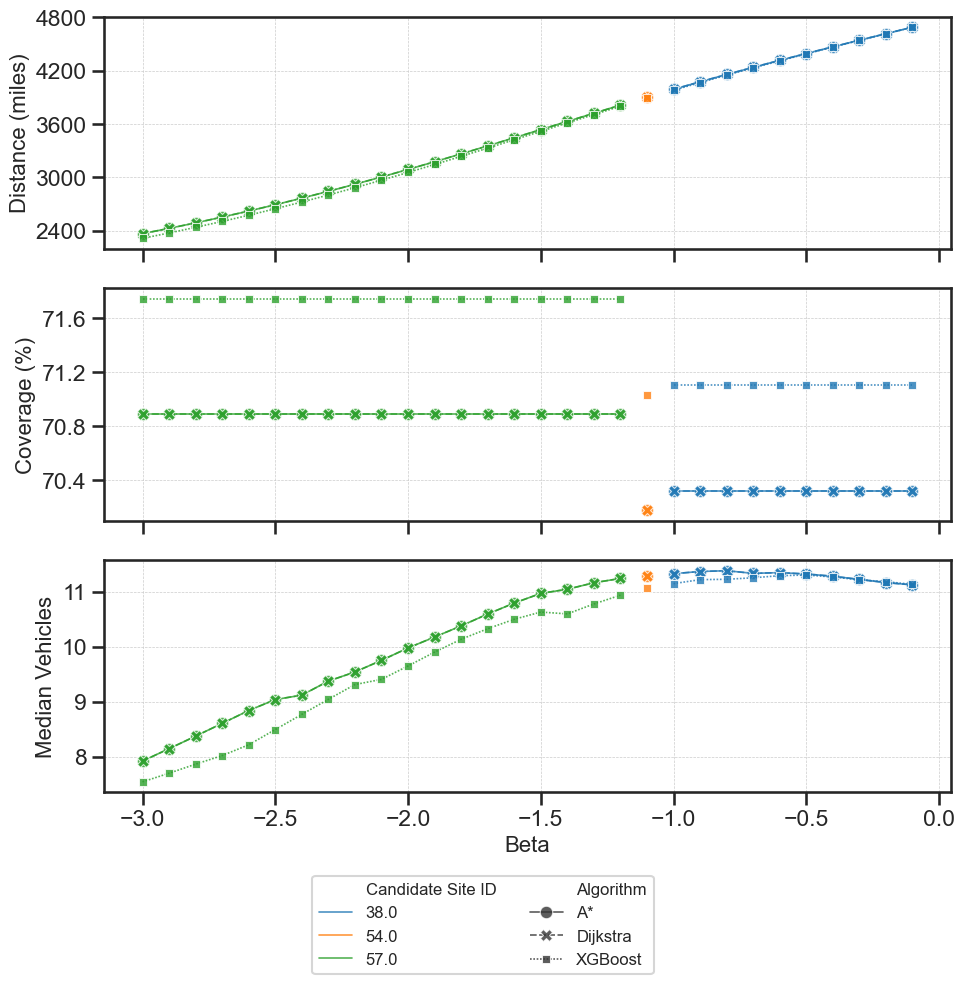

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Set seaborn style for academic-style plots
sns.set_theme(style="ticks", context="talk")

# Create a figure with 3 subplots in one column (vertical layout)
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)  # Share x-axis for Beta

# Define common properties for the lineplots
common_kwargs = {
    "data": ranked_sensitivity_df,
    "x": "Beta",  # X-axis is Beta
    "hue": "Candidate Site ID",
    "style": "Algorithm",  # Different line styles for algorithms
    "palette": "tab10",  # Distinct colors for Candidate Site IDs
    "markers": True,
    "linewidth": 1.2,
    "alpha": 0.8,  # Slight transparency to avoid visual clutter
}

# Plot Total Path Distance
sns.lineplot(ax=axes[0], y="Total Path Distance", **common_kwargs)
axes[0].set_ylabel("Distance (miles)", fontsize=16)
axes[0].grid(True, linestyle="--", linewidth=0.5)

# Plot Coverage Percentage
sns.lineplot(ax=axes[1], y="Coverage Percentage", **common_kwargs)
axes[1].set_ylabel("Coverage (%)", fontsize=16)
axes[1].grid(True, linestyle="--", linewidth=0.5)

# Plot Median Vehicles per Station
sns.lineplot(ax=axes[2], y="Median Vehicles per Station", **common_kwargs)
axes[2].set_ylabel("Median Vehicles", fontsize=16)
axes[2].grid(True, linestyle="--", linewidth=0.5)

# Set common x-axis label
axes[2].set_xlabel("Beta", fontsize=16)

# Customize ticks on each axis
for ax in axes:
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Increase number of y-axis ticks
    ax.xaxis.set_major_locator(MaxNLocator(nbins=7))  # Increase number of x-axis ticks

# Remove the legend from individual plots
for ax in axes:
    ax.legend().remove()

# Add a single legend below the third image
handles, labels = axes[2].get_legend_handles_labels()  # Get legend information
fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    fontsize=12,
    ncol=2,  # Arrange legend items in 2 columns
    frameon=True,
    bbox_to_anchor=(0.5, -0.0),  # Place the legend below the plots
)

# Adjust layout to reduce space between subplots
plt.subplots_adjust(hspace=0.2)  # Reduce vertical spacing between plots
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for the legend
plt.show()

# END